In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity
import pandas as pd
import seaborn as sns

2023-09-15 12:18:09.328497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 12:18:10.067157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.data.components.utils import (get_mjj, get_jet_data, get_nonrel_consts, sort_consts, sort_jets)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [4]:
from jetnet.evaluation import w1efp, w1m, w1p
from src.utils.jet_substructure import dump_hlvs
from src.data.components.metrics import wasserstein_distance_batched
from src.utils.plotting import (
    plot_substructure,
    plot_full_substructure,
)

In [5]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [6]:
data_folder = os.environ.get("DATA_DIR")

# load data

In [7]:
path_preds = "/beegfs/desy/user/ewencedr/data/lhco/preds.h5"
with h5py.File(path_preds, "r") as f:
    pred = f["preds"][:]
    semi_labels = f["semi_labels"][:]
    sample_mjj = f["mjj"][:]
    sample_j = f["sample_j"][:]
    sample_p = f["sample_p"][:]

In [8]:
print(sample_p.shape)

(222351, 2, 279, 3)


In [9]:
#revert pre-processing
def LoadJson(file_name):
    import json,yaml
    JSONPATH = os.path.join(file_name)
    return yaml.safe_load(open(JSONPATH))
data_dict = LoadJson('/home/ewencedr/LHCO_diffusion/scripts/preprocessing_279.json')
batch_size = sample_p.shape[0]
num_part = sample_p.shape[2]
sample_p=sample_p.reshape(-1,sample_p.shape[-1])
mask = np.expand_dims(sample_p[:,0]!=0,-1)
sample_p = sample_p*data_dict['std_particle'] + data_dict['mean_particle']

sample_p[:,0] = 1.0 - np.exp(sample_p[:,0])
sample_p[:,0] = np.clip(sample_p[:,0],2.5349376295699686e-05,1.0) #apply min pt cut
sample_p = (sample_p*mask).reshape(batch_size,2,num_part,-1)
print(sample_p.shape)



(222351, 2, 279, 3)


In [10]:
# revert jet data preprocessing
sample_j = sample_j.reshape(-1,sample_j.shape[-1])
mjj_tile = np.expand_dims(sample_mjj,1)
mjj_tile = np.reshape(np.tile(mjj_tile,(1,2)),(-1))
sample_j = sample_j*data_dict['std_jet'] + data_dict['mean_jet']
sample_j[:,0] = np.exp(sample_j[:,0])*mjj_tile
sample_j[:,4] = np.round(sample_j[:,4])
sample_j[:,4] = np.clip(sample_j[:,4],1,279)
#1 particle jets have 0 mass
mask_mass = sample_j[:,4]>1.0
sample_j[:,3] = np.exp(sample_j[:,3])*mask_mass*mjj_tile
sample_j = sample_j.reshape(batch_size,2,-1)
print(sample_j.shape)

(222351, 2, 5)


In [11]:
pred_bool = pred > 0.5
pred_bool = pred_bool.squeeze()

In [12]:
correct = pred_bool == semi_labels
accuracy = np.sum(correct) / len(correct)
print(f"ACC: {accuracy}")

ACC: 0.8391687017373433


In [13]:
print(np.sum(correct))
print(np.sum(~correct))

186590
35761


In [14]:
def sort_pt(array):
    
    pt = array[...,0]
    #print(pt[0,0,:10])
    eta = array[...,1]
    phi = array[...,2]
    args = np.argsort(pt, axis=-1)[...,::-1]
    #print(pt.shape)
    #print(args.shape)
    
    pt2 = np.take_along_axis(pt, args, axis=-1)
    #print(pt2[0,0,:10])
    eta2 = np.take_along_axis(eta, args, axis=-1)
    phi2 = np.take_along_axis(phi, args, axis=-1)
    return np.stack([pt2, eta2, phi2], axis=-1)

In [15]:
sample_p = sort_pt(sample_p)

In [16]:
correct_j = sample_j[correct]
false_j = sample_j[~correct]
correct_mjj = sample_mjj[correct]
false_mjj = sample_mjj[~correct]
correct_p = sample_p[correct]
false_p = sample_p[~correct]

In [17]:
print(correct_j.shape)
print(correct_p.shape)
print(false_j.shape)
print(false_p.shape)

(186590, 2, 5)
(186590, 2, 279, 3)
(35761, 2, 5)
(35761, 2, 279, 3)


## look at dijet features

In [18]:
print(correct_p.shape)

(186590, 2, 279, 3)


In [19]:
particles_correct_nonrel = get_nonrel_consts(correct_j, correct_p)
particles_false_nonrel = get_nonrel_consts(false_j, false_p)
print(particles_correct_nonrel.shape)

(186590, 2, 279, 3)


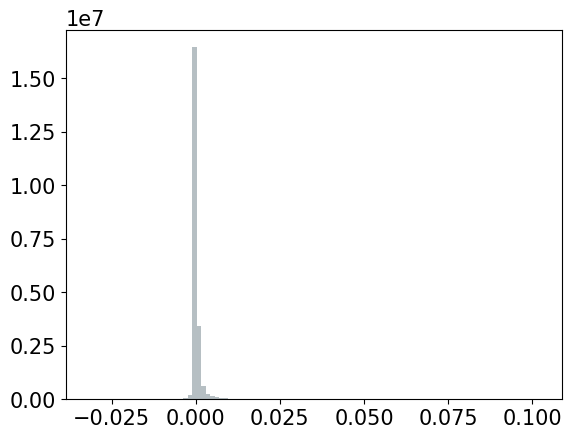

In [20]:
i = 0
plt.hist(particles_correct_nonrel[..., i].flatten()[particles_correct_nonrel[...,i].flatten() != 0], bins=100)
plt.show()

In [21]:
jet_correctly_classified = get_jet_data(particles_correct_nonrel)
jet_false_classified = get_jet_data(particles_false_nonrel)

In [22]:
print(jet_correctly_classified.shape)

(186590, 2, 4)


In [23]:
print(correct_j.shape)

(186590, 2, 5)


In [24]:
#mjj_correctly_classified = get_mjj(jet_correctly_classified[:,0], jet_correctly_classified[:,1])
#mjj_false_classified = get_mjj(jet_false_classified[:,0], jet_false_classified[:,1])
mjj_correctly_classified = get_mjj(correct_j[:,0,:4], correct_j[:,1,:4])
mjj_false_classified = get_mjj(false_j[:,0,:4], false_j[:,1,:4])

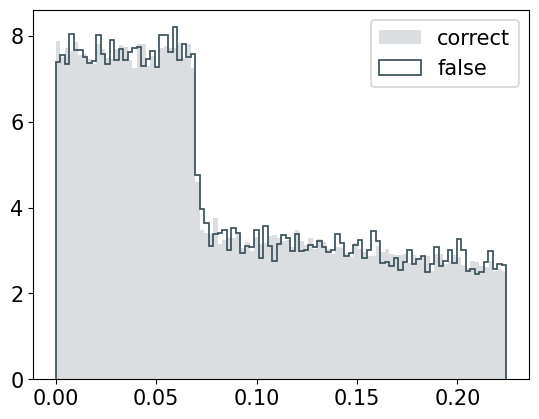

In [25]:
min_bin, max_bin = min(np.min(mjj_correctly_classified), np.min(mjj_false_classified)), max(np.max(mjj_correctly_classified), np.max(mjj_false_classified))
hist = plt.hist(mjj_correctly_classified, bins=100, alpha=0.5, label="correct", density=True, range=(min_bin, max_bin))
plt.hist(mjj_false_classified, bins=100, label="false", density=True, histtype="step")
plt.legend()
plt.show()

In [26]:
print(jet_features_id.shape)

NameError: name 'jet_features_id' is not defined

In [ ]:
p4_jets_x = ef.p4s_from_ptyphims(jet_features_id[:,0,:4])
p4_jets_y = ef.p4s_from_ptyphims(jet_features_id[:,1,:4])
sum_p4 = p4_jets_x + p4_jets_y
mjj = ef.ms_from_p4s(sum_p4)

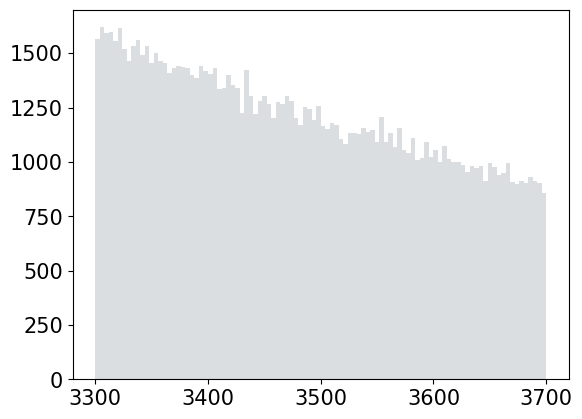

In [ ]:
plt.hist(mjj, bins=100, alpha=0.5, label="correct")
plt.show()

# look at substructure of correctly vs incorrectly classified events

In [40]:
# load data 
path_true_data = "/beegfs/desy/user/ewencedr/data/lhco/generated/idealized_LHCO_shuffled.h5"
#path_true_data = "/beegfs/desy/user/ewencedr/data/lhco/generated/SB_idealized_120k.h5"
with h5py.File(path_true_data, "r") as f:
    jet_features_id = f["jet_features"][:]
    particle_data_id = f["particle_features"][:]
    mjj_id = f["mjj"][:]

In [41]:
# load data 
path_true_datav = "/beegfs/desy/user/ewencedr/data/lhco/generated/FPCD_LHCO_SR_shuffled.h5"
with h5py.File(path_true_datav, "r") as f:
    jet_features_v = f["jet_features"][:]
    particle_data_v = f["particle_features"][:]
    mjj_v = f["mjj"][:]

In [42]:
# load data 
path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-10layer-256latent-logpt-new2m_sr-midpoint-300_shuffled.h5"
#path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/both_jets2_nnew2_sr-midpoint-300.h5"
#path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/both_jets-100p-not-nnew_sr-midpoint-300.h5"
#path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-10layer-256latent-logpt-new2_sr-euler-500.h5"
#path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/vhighconfig-mass-ordered-2-midpoint-250.h5"
#path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-13layer_sr-midpoint-300.h5"
#path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-setup2_sr-midpoint-300.h5"

#path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-256-logpt-sbtest_sb-midpoint-300.h5"






with h5py.File(path_true_datac, "r") as f:
    jet_features_c = f["jet_features"][:]
    particle_data_c = f["particle_features"][:]
    #particle_features_nonrel_c = f["particle_features_nonrel"][:]
    mjj_c = f["mjj"][:]

In [111]:
print(jet_features_c.shape)

(121351, 2, 5)


In [43]:
# sort jets by pt
jet_features_id, particle_data_id = sort_jets(jet_features_id, particle_data_id, sort_by="pt")
jet_features_c, particle_data_c = sort_jets(jet_features_c, particle_data_c, sort_by="pt")
jet_features_v, particle_data_v = sort_jets(jet_features_v, particle_data_v, sort_by="pt")

In [44]:
# sort constituents by pt
particle_data_id = sort_consts(particle_data_id, sort_by="pt")
particle_data_c = sort_consts(particle_data_c, sort_by="pt")
particle_data_v = sort_consts(particle_data_v, sort_by="pt")

In [45]:
print(particle_data_id.shape)
print(particle_data_v.shape)
print(particle_data_c.shape)

(121351, 2, 279, 3)
(121351, 2, 279, 3)
(121351, 2, 279, 3)


In [46]:
particle_data_v = particle_data_v[:len(particle_data_id)]
jet_features_v = jet_features_v[:len(jet_features_id)]
mjj_v = mjj_v[:len(mjj_id)]

### look at high level features

In [47]:
nonrel_data_id = get_nonrel_consts(jet_features_id, particle_data_id)
nonrel_data_v = get_nonrel_consts(jet_features_v, particle_data_v)
nonrel_data_c = get_nonrel_consts(jet_features_c, particle_data_c)

In [133]:
calc_jet_features_id = get_jet_data(nonrel_data_id)
calc_jet_features_v = get_jet_data(nonrel_data_v)
calc_jet_features_c = get_jet_data(nonrel_data_c)

In [134]:
mask_particle_data_id = particle_data_id[...,0] != 0
particle_multiplicity_id = np.sum(mask_particle_data_id, axis=-1)
calc_jet_features_id = np.concatenate([calc_jet_features_id, np.expand_dims(particle_multiplicity_id, axis=-1)], axis=-1)
mask_particle_data_c = particle_data_c[...,0] != 0
particle_multiplicity_c = np.sum(mask_particle_data_c, axis=-1)
calc_jet_features_c = np.concatenate([calc_jet_features_c, np.expand_dims(particle_multiplicity_c, axis=-1)], axis=-1)
mask_particle_data_v = particle_data_v[...,0] != 0
particle_multiplicity_v = np.sum(mask_particle_data_v, axis=-1)
calc_jet_features_v = np.concatenate([calc_jet_features_v, np.expand_dims(particle_multiplicity_v, axis=-1)], axis=-1)
print(calc_jet_features_id.shape)
print(calc_jet_features_v.shape)
print(calc_jet_features_c.shape)

(121351, 2, 5)
(121351, 2, 5)
(121351, 2, 5)


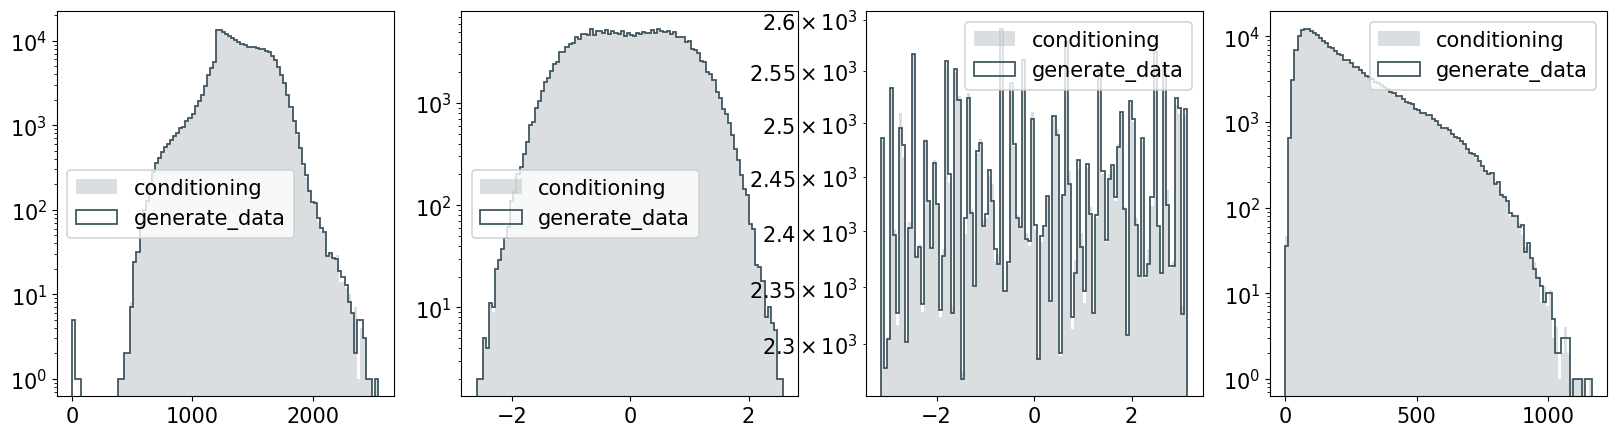

In [135]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(calc_jet_features_id[:,i]), np.min(calc_jet_features_v[:,i])), max(np.max(calc_jet_features_id[:,i]), np.max(calc_jet_features_v[:,i]))
    min_bin, max_bin = min(np.min(jet_features_c[...,i]), np.min(calc_jet_features_c[...,i])), max(np.max(jet_features_c[...,i]), np.max(calc_jet_features_c[...,i]))
    ax.hist(jet_features_c[...,i].flatten(), bins=100, alpha=0.5, label="conditioning", range=(min_bin, max_bin))
    ax.hist(calc_jet_features_c[...,i].flatten(), bins=100, label="generate_data", histtype="step")
    ax.legend()
    ax.set_yscale("log")
plt.show()

first jet

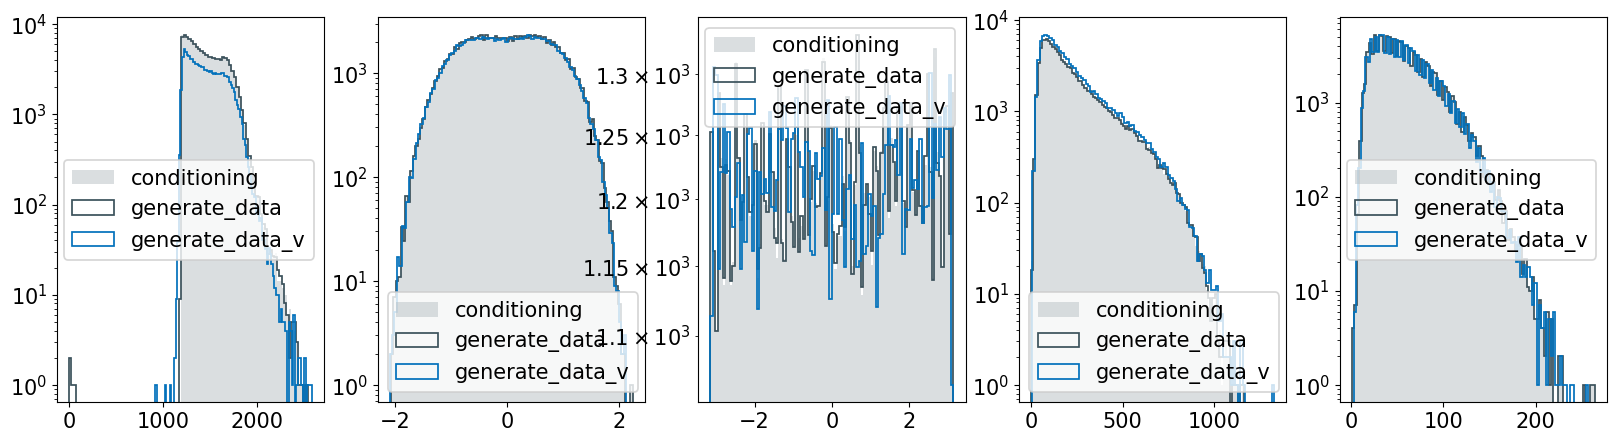

In [136]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(calc_jet_features_id[:,i]), np.min(calc_jet_features_v[:,i])), max(np.max(calc_jet_features_id[:,i]), np.max(calc_jet_features_v[:,i]))
    min_bin, max_bin = min(np.min(jet_features_c[...,i][:,0]), np.min(calc_jet_features_c[...,i][:,0])), max(np.max(jet_features_c[...,i][:,0]), np.max(calc_jet_features_c[...,i][:,0]))
    ax.hist(jet_features_c[...,i][:,0].flatten(), bins=100, alpha=0.5, label="conditioning", range=(min_bin, max_bin))
    ax.hist(calc_jet_features_c[...,i][:,0].flatten(), bins=100, label="generate_data", histtype="step")
    ax.hist(calc_jet_features_v[...,i][:,0].flatten(), bins=100, label="generate_data_v", histtype="step")
    ax.legend()
    ax.set_yscale("log")
plt.show()

In [51]:
calc_mjj_id = get_mjj(calc_jet_features_id[:,0,:4], calc_jet_features_id[:,1,:4])
calc_mjj_v = get_mjj(calc_jet_features_v[:,0,:4], calc_jet_features_v[:,1,:4])
calc_mjj_c = get_mjj(calc_jet_features_c[:,0,:4], calc_jet_features_c[:,1,:4])

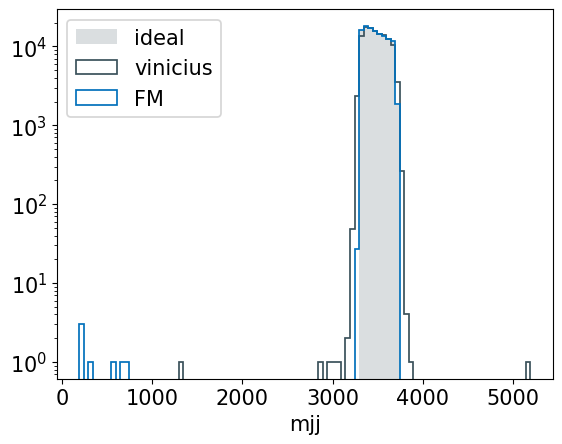

In [52]:
min_bin, max_bin = min(np.min(calc_mjj_id), np.min(calc_mjj_v), np.min(calc_mjj_c)), max(np.max(calc_mjj_id), np.max(calc_mjj_v), np.max(calc_mjj_c))
plt.hist(calc_mjj_id, bins=100, alpha=0.5, label="ideal", range=(min_bin, max_bin))
plt.hist(calc_mjj_v, bins=100, label="vinicius", histtype="step", range=(min_bin, max_bin))
plt.hist(calc_mjj_c, bins=100, label="FM", histtype="step", range=(min_bin, max_bin))
plt.legend()
plt.yscale("log")
plt.xlabel("mjj")
plt.show()

### delta R between jets

In [53]:
def get_deltaR(jet_features: np.ndarray) -> np.ndarray:
    """Calculate deltaR between two jets

    Args:
        jet_features (np.ndarray): jet features (pt, eta, phi, mass)

    Returns:
        np.ndarray: delta R between two jets
    """
    eta1 = jet_features[:,0,1]
    phi1 = jet_features[:,0,2]
    eta2 = jet_features[:,1,1]
    phi2 = jet_features[:,1,2]
    return np.sqrt((eta1-eta2)**2 + (phi1-phi2)**2)

In [54]:
deltaR_id = get_deltaR(calc_jet_features_id)
deltaR_v = get_deltaR(calc_jet_features_v)
deltaR_c = get_deltaR(calc_jet_features_c)

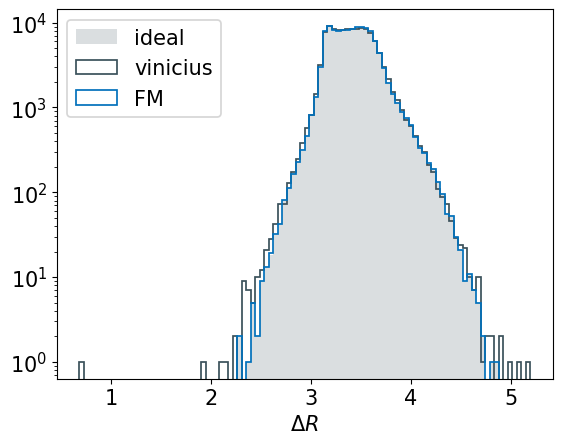

In [55]:
min_bin, max_bin = min(np.min(deltaR_id), np.min(deltaR_v), np.min(deltaR_c)), max(np.max(deltaR_id), np.max(deltaR_v), np.max(deltaR_c))
plt.hist(deltaR_id, bins=100, alpha=0.5, label="ideal", range=(min_bin, max_bin))
plt.hist(deltaR_v, bins=100, label="vinicius", histtype="step", range=(min_bin, max_bin))
plt.hist(deltaR_c, bins=100, label="FM", histtype="step", range=(min_bin, max_bin))
plt.legend()
plt.yscale("log")
plt.xlabel(r"$\Delta R$")
plt.show()

In [56]:
delta_pt_jet_id = abs(calc_jet_features_id[:,0,0] - calc_jet_features_id[:,1,0])
delta_pt_jet_v = abs(calc_jet_features_v[:,0,0] - calc_jet_features_v[:,1,0])
delta_pt_jet_c = abs(calc_jet_features_c[:,0,0] - calc_jet_features_c[:,1,0])

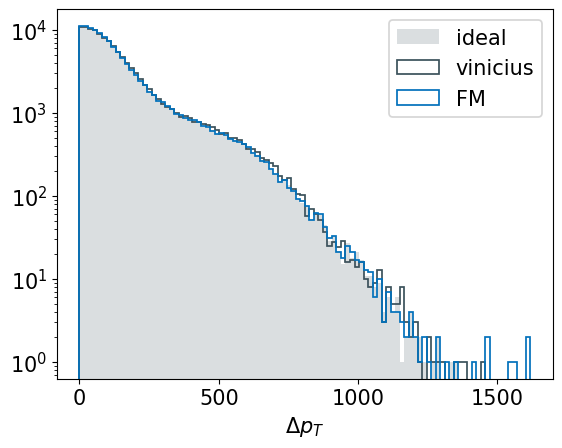

In [57]:
min_bin, max_bin = min(np.min(delta_pt_jet_id), np.min(delta_pt_jet_v), np.min(delta_pt_jet_c)), max(np.max(delta_pt_jet_id), np.max(delta_pt_jet_v), np.max(delta_pt_jet_c))
plt.hist(delta_pt_jet_id, bins=100, alpha=0.5, label="ideal", range=(min_bin, max_bin))
plt.hist(delta_pt_jet_v, bins=100, label="vinicius", histtype="step", range=(min_bin, max_bin))
plt.hist(delta_pt_jet_c, bins=100, label="FM", histtype="step", range=(min_bin, max_bin))
plt.legend()
plt.yscale("log")
plt.xlabel(r"$\Delta p_T$")
plt.show()

## substructure for each jet

In [58]:
print((particle_data_id[...,[1,2,0]][:10000,0]).shape)

(10000, 279, 3)


In [61]:
dump_hlvs(
    particle_data_id[...,[1,2,0]][:10000,0],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet1_id_pto",
    plot=False,
)

Computing substructure variables: 100%|██████████| 10000/10000 [02:13<00:00, 74.75it/s]


In [62]:
dump_hlvs(
    particle_data_id[...,[1,2,0]][:10000,1],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet2_id_pto",
    plot=False,
)

Computing substructure variables: 100%|██████████| 10000/10000 [02:03<00:00, 80.83it/s]


In [63]:
dump_hlvs(
    particle_data_c[...,[1,2,0]][:10000,0],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet1_c_both_jets2_pto",
    plot=False,
)

Computing substructure variables: 100%|██████████| 10000/10000 [02:15<00:00, 73.63it/s]


In [64]:
dump_hlvs(
    particle_data_c[...,[1,2,0]][:10000,1],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet2_c_both_jets2_pto",
    plot=False,
)

Computing substructure variables:  69%|██████▉   | 6944/10000 [01:24<00:40, 75.42it/s] /home/ewencedr/deep-learning/notebooks/../src/utils/jet_substructure.py:484: RuntimeWarning: invalid value encountered in double_scalars
  tau_32s.append(tau3 / tau2)
Computing substructure variables: 100%|██████████| 10000/10000 [02:02<00:00, 81.86it/s]


In [65]:
dump_hlvs(
    particle_data_v[...,[1,2,0]][:10000,0],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet1_pto",
    plot=False,
)

Computing substructure variables: 100%|██████████| 10000/10000 [02:10<00:00, 76.88it/s]


In [75]:
dump_hlvs(
    particle_data_v[...,[1,2,0]][:10000,1],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet2_pto",
    plot=False,
)

Computing substructure variables: 100%|██████████| 10000/10000 [02:08<00:00, 77.64it/s]


In [76]:
# load substructure for id data
data_substructure_id1 = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet1_id_pto" + ".h5", "r") as f:
    tau21_id1 = np.nan_to_num(np.array(f["tau21"]))
    tau32_id1 = np.nan_to_num(np.array(f["tau32"]))
    d2_id1 = np.nan_to_num(np.array(f["d2"]))
    for key in f.keys():
        data_substructure_id1.append(np.array(f[key]))
data_substructure_id1 = np.array(data_substructure_id1)

In [77]:
# load substructure for id data
data_substructure_id2 = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet2_id_pto" + ".h5", "r") as f:
    tau21_id2 = np.nan_to_num(np.array(f["tau21"]))
    tau32_id2 = np.nan_to_num(np.array(f["tau32"]))
    d2_id2 = np.nan_to_num(np.array(f["d2"]))
    for key in f.keys():
        data_substructure_id2.append(np.array(f[key]))
data_substructure_id2 = np.array(data_substructure_id2)

In [78]:
# load substructure for id data
data_substructure_c1 = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet1_c_both_jets2_pto" + ".h5", "r") as f:
    tau21_c1 = np.nan_to_num(np.array(f["tau21"]))
    tau32_c1 = np.nan_to_num(np.array(f["tau32"]))
    d2_c1 = np.nan_to_num(np.array(f["d2"]))
    for key in f.keys():
        data_substructure_c1.append(np.array(f[key]))
data_substructure_c1 = np.array(data_substructure_c1)

In [79]:
# load substructure for id data
data_substructure_c2 = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet2_c_both_jets2_pto" + ".h5", "r") as f:
    tau21_c2 = np.nan_to_num(np.array(f["tau21"]))
    tau32_c2 = np.nan_to_num(np.array(f["tau32"]))
    d2_c2 = np.nan_to_num(np.array(f["d2"]))
    for key in f.keys():
        data_substructure_c2.append(np.array(f[key]))
data_substructure_c2 = np.array(data_substructure_c2)

In [80]:
# load substructure for id data
data_substructure_v1 = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet1_pto" + ".h5", "r") as f:
    tau21_v1 = np.nan_to_num(np.array(f["tau21"]))
    tau32_v1 = np.nan_to_num(np.array(f["tau32"]))
    d2_v1 = np.nan_to_num(np.array(f["d2"]))
    for key in f.keys():
        data_substructure_v1.append(np.array(f[key]))
data_substructure_v1 = np.array(data_substructure_v1)

In [81]:
# load substructure for id data
data_substructure_v2 = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_jet2_pto" + ".h5", "r") as f:
    tau21_v2 = np.nan_to_num(np.array(f["tau21"]))
    tau32_v2 = np.nan_to_num(np.array(f["tau32"]))
    d2_v2 = np.nan_to_num(np.array(f["d2"]))
    for key in f.keys():
        data_substructure_v2.append(np.array(f[key]))
data_substructure_v2 = np.array(data_substructure_v2)

In [82]:
delta_tau21_id = abs(tau21_id1 - tau21_id2)
delta_tau21_c = abs(tau21_c1 - tau21_c2)
delta_tau21_v = abs(tau21_v1 - tau21_v2)
delta_tau32_id = abs(tau32_id1 - tau32_id2)
delta_tau32_c = abs(tau32_c1 - tau32_c2)
delta_tau32_v = abs(tau32_v1 - tau32_v2)
delta_d2_id = abs(d2_id1 - d2_id2)
delta_d2_c = abs(d2_c1 - d2_c2)
delta_d2_v = abs(d2_v1 - d2_v2)

In [83]:
print(np.min(delta_tau21_id), np.max(delta_tau21_id))
print(np.min(delta_tau21_c), np.max(delta_tau21_c))
print(np.min(delta_tau21_v), np.max(delta_tau21_v))

2.7000725249526347e-06 1.125236820321766
7.678680368494728e-05 1.2102446392665045
1.3268507393804363e-05 1.0567575879776898


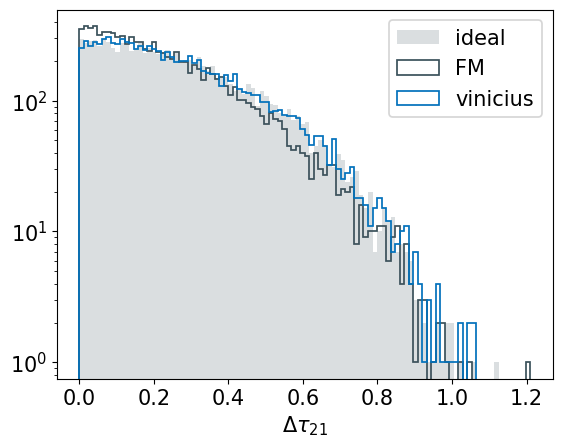

In [84]:
min_bin, max_bin = min(np.min(delta_tau21_id), np.min(delta_tau21_c), np.min(delta_tau21_v)), max(np.max(delta_tau21_id), np.max(delta_tau21_c), np.max(delta_tau21_v))
plt.hist(delta_tau21_id, bins=100, alpha=0.5, label="ideal", range=(min_bin, max_bin))
plt.hist(delta_tau21_c, bins=100, label="FM", histtype="step", range=(min_bin, max_bin))
plt.hist(delta_tau21_v, bins=100, label="vinicius", histtype="step", range=(min_bin, max_bin))
plt.legend()
plt.yscale("log")
plt.xlabel(r"$\Delta \tau_{21}$")
plt.show()

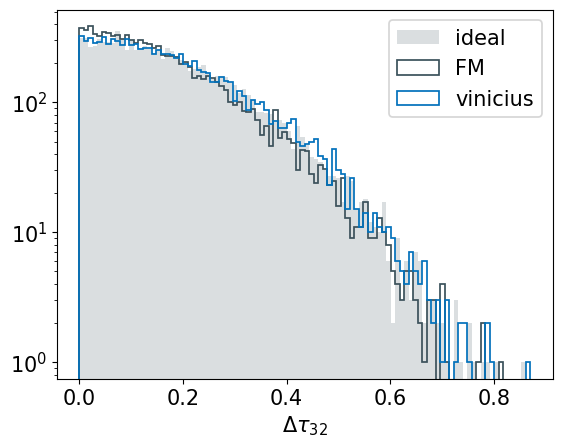

In [85]:
min_bin, max_bin = min(np.min(delta_tau32_id), np.min(delta_tau32_c), np.min(delta_tau32_v)), max(np.max(delta_tau32_id), np.max(delta_tau32_c), np.max(delta_tau32_v))
plt.hist(delta_tau32_id, bins=100, alpha=0.5, label="ideal", range=(min_bin, max_bin))
plt.hist(delta_tau32_c, bins=100, label="FM", histtype="step", range=(min_bin, max_bin))
plt.hist(delta_tau32_v, bins=100, label="vinicius", histtype="step", range=(min_bin, max_bin))
plt.legend()
plt.yscale("log")
plt.xlabel(r"$\Delta \tau_{32}$")
plt.show()

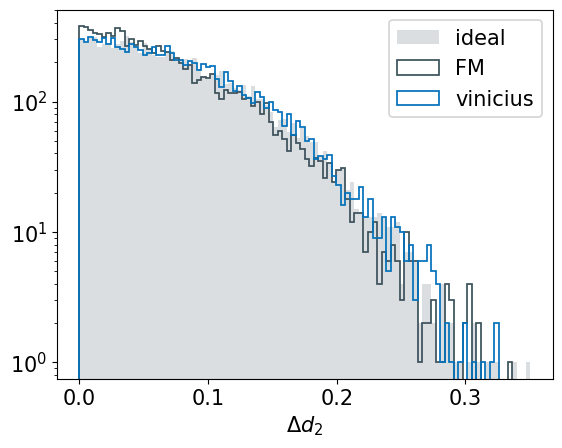

In [86]:
min_bin, max_bin = min(np.min(delta_d2_id), np.min(delta_d2_c), np.min(delta_d2_v)), max(np.max(delta_d2_id), np.max(delta_d2_c), np.max(delta_d2_v))
plt.hist(delta_d2_id, bins=100, alpha=0.5, label="ideal", range=(min_bin, max_bin))
plt.hist(delta_d2_c, bins=100, label="FM", histtype="step", range=(min_bin, max_bin))
plt.hist(delta_d2_v, bins=100, label="vinicius", histtype="step", range=(min_bin, max_bin))
plt.legend()
plt.yscale("log")
plt.xlabel(r"$\Delta d_2$")
plt.show()

## correlations plot

In [137]:
delta_pt_jet_id_plot = delta_pt_jet_id[:len(delta_tau21_id)]
delta_pt_jet_c_plot = delta_pt_jet_c[:len(delta_tau21_c)]
delta_pt_jet_v_plot = delta_pt_jet_v[:len(delta_tau21_v)]

deltaR_id_plot = deltaR_id[:len(delta_tau21_id)]
deltaR_c_plot = deltaR_c[:len(delta_tau21_c)]
deltaR_v_plot = deltaR_v[:len(delta_tau21_v)]

calc_mjj_id_plot = calc_mjj_id[:len(delta_tau21_id)]
calc_mjj_c_plot = calc_mjj_c[:len(delta_tau21_c)]
calc_mjj_v_plot = calc_mjj_v[:len(delta_tau21_v)]

calc_jet_features_id_plot = calc_jet_features_id[:len(delta_tau21_id)]
calc_jet_features_c_plot = calc_jet_features_c[:len(delta_tau21_c)]
calc_jet_features_v_plot = calc_jet_features_v[:len(delta_tau21_v)]
jet_features_id_plot = jet_features_id[:len(delta_tau21_id)]
jet_features_c_plot = jet_features_c[:len(delta_tau21_c)]
jet_features_v_plot = jet_features_v[:len(delta_tau21_v)]

mass_1_id_plot = calc_jet_features_id_plot[:,0,3]
mass_1_c_plot = calc_jet_features_c_plot[:,0,3]
mass_1_v_plot = calc_jet_features_v_plot[:,0,3]
mass_1_id_plot_cond = jet_features_id_plot[:,0,3]
mass_1_c_plot_cond = jet_features_c_plot[:,0,3]
mass_1_v_plot_cond = jet_features_v_plot[:,0,3]

mass_2_id_plot = calc_jet_features_id_plot[:,1,3]
mass_2_c_plot = calc_jet_features_c_plot[:,1,3]
mass_2_v_plot = calc_jet_features_v_plot[:,1,3]
mass_2_id_plot_cond = jet_features_id_plot[:,1,3]
mass_2_c_plot_cond = jet_features_c_plot[:,1,3]
mass_2_v_plot_cond = jet_features_v_plot[:,1,3]

pt_1_id_plot = calc_jet_features_id_plot[:,0,0]
pt_1_c_plot = calc_jet_features_c_plot[:,0,0]
pt_1_v_plot = calc_jet_features_v_plot[:,0,0]
pt_1_id_plot_cond = jet_features_id_plot[:,0,0]
pt_1_c_plot_cond = jet_features_c_plot[:,0,0]
pt_1_v_plot_cond = jet_features_v_plot[:,0,0]

pt_2_id_plot = calc_jet_features_id_plot[:,1,0]
pt_2_c_plot = calc_jet_features_c_plot[:,1,0]
pt_2_v_plot = calc_jet_features_v_plot[:,1,0]
pt_2_id_plot_cond = jet_features_id_plot[:,1,0]
pt_2_c_plot_cond = jet_features_c_plot[:,1,0]
pt_2_v_plot_cond = jet_features_v_plot[:,1,0]

eta_1_id_plot = calc_jet_features_id_plot[:,0,1]
eta_1_c_plot = calc_jet_features_c_plot[:,0,1]
eta_1_v_plot = calc_jet_features_v_plot[:,0,1]
eta_1_id_plot_cond = jet_features_id_plot[:,0,1]
eta_1_c_plot_cond = jet_features_c_plot[:,0,1]
eta_1_v_plot_cond = jet_features_v_plot[:,0,1]

eta_2_id_plot = calc_jet_features_id_plot[:,1,1]
eta_2_c_plot = calc_jet_features_c_plot[:,1,1]
eta_2_v_plot = calc_jet_features_v_plot[:,1,1]
eta_2_id_plot_cond = jet_features_id_plot[:,1,1]
eta_2_c_plot_cond = jet_features_c_plot[:,1,1]
eta_2_v_plot_cond = jet_features_v_plot[:,1,1]

phi_1_id_plot = calc_jet_features_id_plot[:,0,2]
phi_1_c_plot = calc_jet_features_c_plot[:,0,2]
phi_1_v_plot = calc_jet_features_v_plot[:,0,2]
phi_1_id_plot_cond = jet_features_id_plot[:,0,2]
phi_1_c_plot_cond = jet_features_c_plot[:,0,2]
phi_1_v_plot_cond = jet_features_v_plot[:,0,2]

phi_2_id_plot = calc_jet_features_id_plot[:,1,2]
phi_2_c_plot = calc_jet_features_c_plot[:,1,2]
phi_2_v_plot = calc_jet_features_v_plot[:,1,2]
phi_2_id_plot_cond = jet_features_id_plot[:,1,2]
phi_2_c_plot_cond = jet_features_c_plot[:,1,2]
phi_2_v_plot_cond = jet_features_v_plot[:,1,2]

multiplicity_1_id_plot = calc_jet_features_id_plot[:,0,4]
multiplicity_1_c_plot = calc_jet_features_c_plot[:,0,4]
multiplicity_1_v_plot = calc_jet_features_v_plot[:,0,4]
multiplicity_1_id_plot_cond = jet_features_id_plot[:,0,4]
multiplicity_1_c_plot_cond = jet_features_c_plot[:,0,4]
multiplicity_1_v_plot_cond = jet_features_v_plot[:,0,4]

multiplicity_2_id_plot = calc_jet_features_id_plot[:,1,4]
multiplicity_2_c_plot = calc_jet_features_c_plot[:,1,4]
multiplicity_2_v_plot = calc_jet_features_v_plot[:,1,4]
multiplicity_2_id_plot_cond = jet_features_id_plot[:,1,4]
multiplicity_2_c_plot_cond = jet_features_c_plot[:,1,4]
multiplicity_2_v_plot_cond = jet_features_v_plot[:,1,4]


In [115]:
print(multiplicity_1_c_plot.shape)

(10000,)


In [109]:
mask_pt_2_id = pt_2_id_plot != 0
print(mask_pt_2_id)

[ True  True  True ...  True  True  True]


## analysis of the most important features

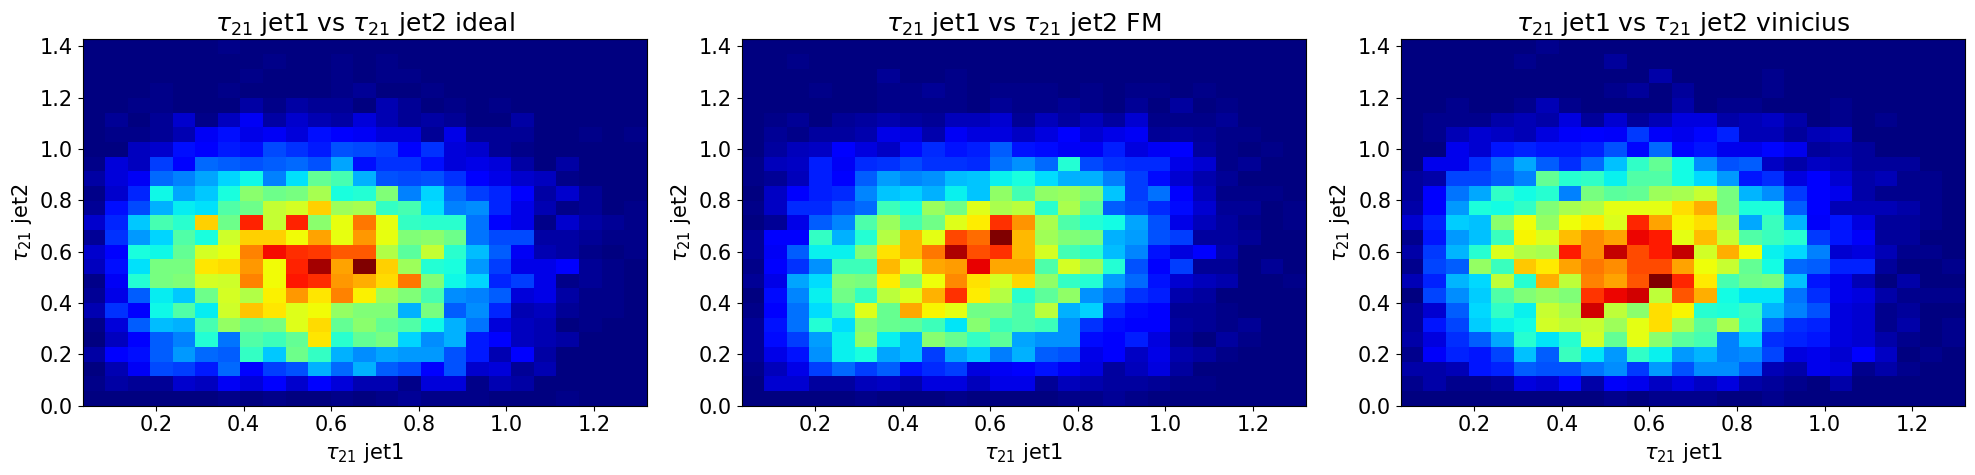

In [88]:
data_x = [tau21_id1, tau21_c1, tau21_v1]
data_y = [tau21_id2, tau21_c2, tau21_v2]
label = ["ideal", "FM", "vinicius"]
quantity1 = r"$\tau_{21}$ jet1"
quantity2 = r"$\tau_{21}$ jet2"
min_bin_x, max_bin_x = min(np.min(data_x[0]), np.min(data_x[1]), np.min(data_x[2])), max(np.max(data_x[0]), np.max(data_x[1]), np.max(data_x[2]))
min_bin_y, max_bin_y = min(np.min(data_y[0]), np.min(data_y[1]), np.min(data_y[2])), max(np.max(data_y[0]), np.max(data_y[1]), np.max(data_y[2]))
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.hist2d(data_x[i], data_y[i], bins=25, cmap="jet", range=[[min_bin_x, max_bin_x], [min_bin_y, max_bin_y]])
    ax.set_xlabel(f"{quantity1}")
    ax.set_ylabel(f"{quantity2}")
    ax.set_title(f"{quantity1} vs {quantity2} {label[i]}")
plt.tight_layout()
plt.show()

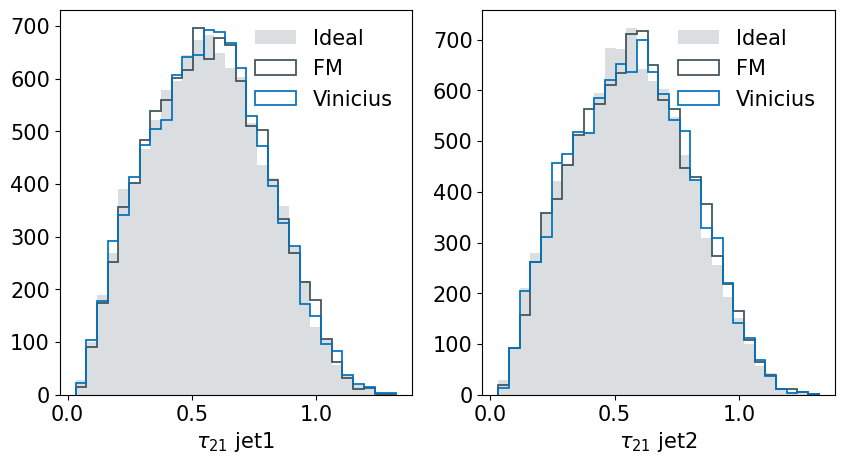

In [89]:
min_bin, max_bin = min(np.min(tau21_id1), np.min(tau21_c1), np.min(tau21_v1)), max(np.max(tau21_id1), np.max(tau21_c1), np.max(tau21_v1))
min_bin1, max_bin2 = min(np.min(tau21_id2), np.min(tau21_c2), np.min(tau21_v2)), max(np.max(tau21_id2), np.max(tau21_c2), np.max(tau21_v2))

bins = 30
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(tau21_id1, bins=bins, alpha=0.5, label="Ideal", range=(min_bin, max_bin))
axs[0].hist(tau21_c1, bins=bins, label="FM", histtype="step", range=(min_bin, max_bin))
axs[0].hist(tau21_v1, bins=bins, label="Vinicius", histtype="step", range=(min_bin, max_bin))
axs[0].legend(frameon=False)
axs[0].set_xlabel(r"$\tau_{21}$ jet1")

axs[1].hist(tau21_id2, bins=bins, alpha=0.5, label="Ideal", range=(min_bin, max_bin))
axs[1].hist(tau21_c2, bins=bins, label="FM", histtype="step", range=(min_bin, max_bin))
axs[1].hist(tau21_v2, bins=bins, label="Vinicius", histtype="step", range=(min_bin, max_bin))
axs[1].legend(frameon=False)
axs[1].set_xlabel(r"$\tau_{21}$ jet2")
plt.show()

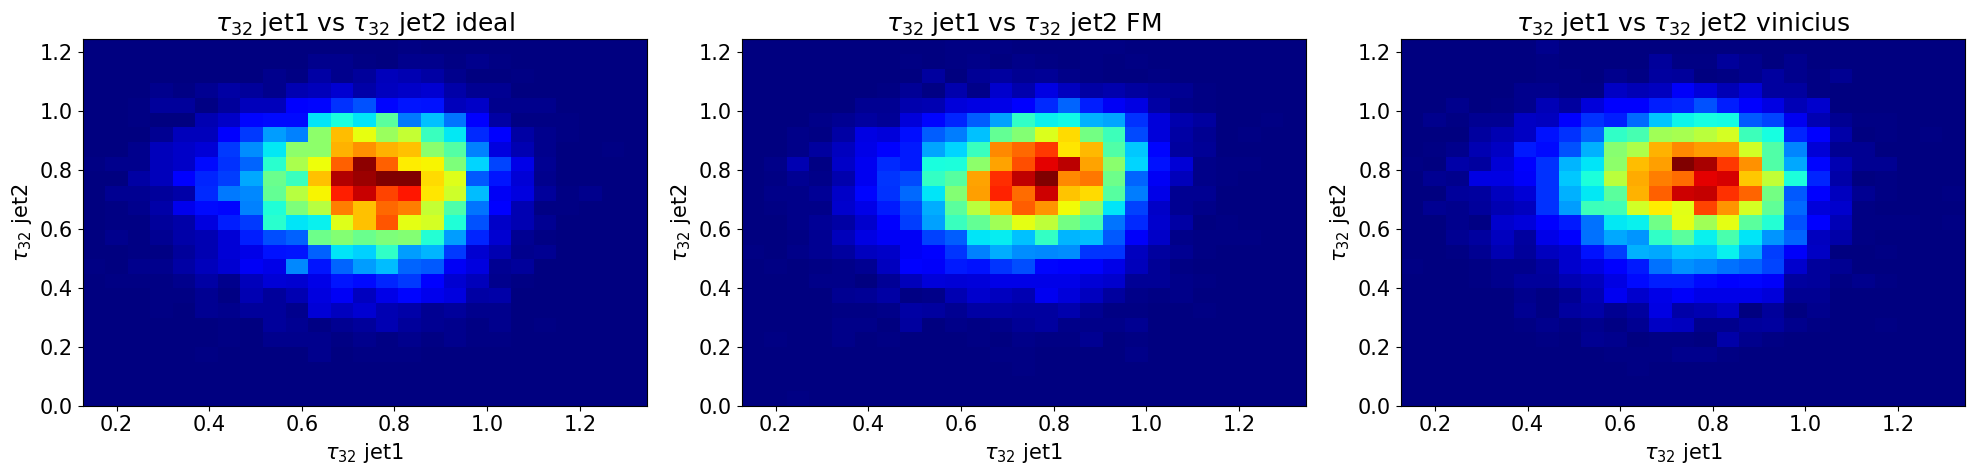

In [90]:
data_x = [tau32_id1, tau32_c1, tau32_v1]
data_y = [tau32_id2, tau32_c2, tau32_v2]
label = ["ideal", "FM", "vinicius"]
quantity1 = r"$\tau_{32}$ jet1"
quantity2 = r"$\tau_{32}$ jet2"
min_bin_x, max_bin_x = min(np.min(data_x[0]), np.min(data_x[1]), np.min(data_x[2])), max(np.max(data_x[0]), np.max(data_x[1]), np.max(data_x[2]))
min_bin_y, max_bin_y = min(np.min(data_y[0]), np.min(data_y[1]), np.min(data_y[2])), max(np.max(data_y[0]), np.max(data_y[1]), np.max(data_y[2]))
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.hist2d(data_x[i], data_y[i], bins=25, cmap="jet", range=[[min_bin_x, max_bin_x], [min_bin_y, max_bin_y]])
    ax.set_xlabel(f"{quantity1}")
    ax.set_ylabel(f"{quantity2}")
    ax.set_title(f"{quantity1} vs {quantity2} {label[i]}")
plt.tight_layout()
plt.show()

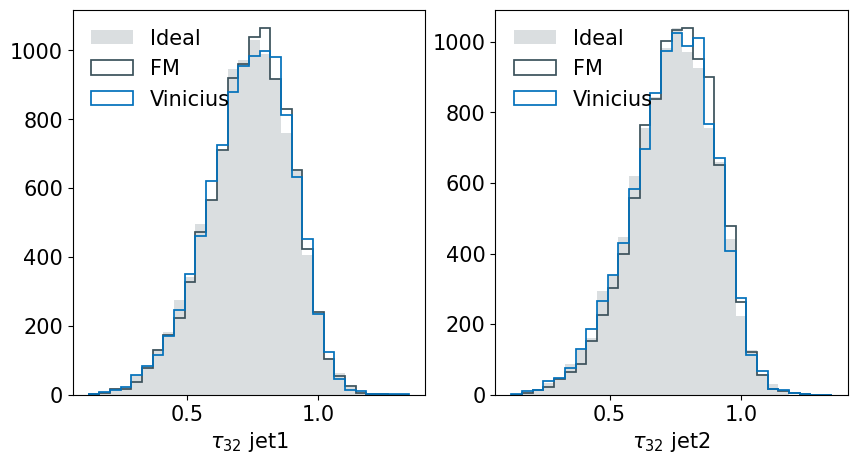

In [91]:
min_bin, max_bin = min(np.min(tau32_id1), np.min(tau32_c1), np.min(tau32_v1)), max(np.max(tau32_id1), np.max(tau32_c1), np.max(tau32_v1))
min_bin1, max_bin2 = min(np.min(tau32_id2), np.min(tau32_c2), np.min(tau32_v2)), max(np.max(tau32_id2), np.max(tau32_c2), np.max(tau32_v2))

bins = 30
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(tau32_id1, bins=bins, alpha=0.5, label="Ideal", range=(min_bin, max_bin))
axs[0].hist(tau32_c1, bins=bins, label="FM", histtype="step", range=(min_bin, max_bin))
axs[0].hist(tau32_v1, bins=bins, label="Vinicius", histtype="step", range=(min_bin, max_bin))
axs[0].legend(frameon=False)
axs[0].set_xlabel(r"$\tau_{32}$ jet1")

axs[1].hist(tau32_id2, bins=bins, alpha=0.5, label="Ideal", range=(min_bin, max_bin))
axs[1].hist(tau32_c2, bins=bins, label="FM", histtype="step", range=(min_bin, max_bin))
axs[1].hist(tau32_v2, bins=bins, label="Vinicius", histtype="step", range=(min_bin, max_bin))
axs[1].legend(frameon=False)
axs[1].set_xlabel(r"$\tau_{32}$ jet2")
plt.show()

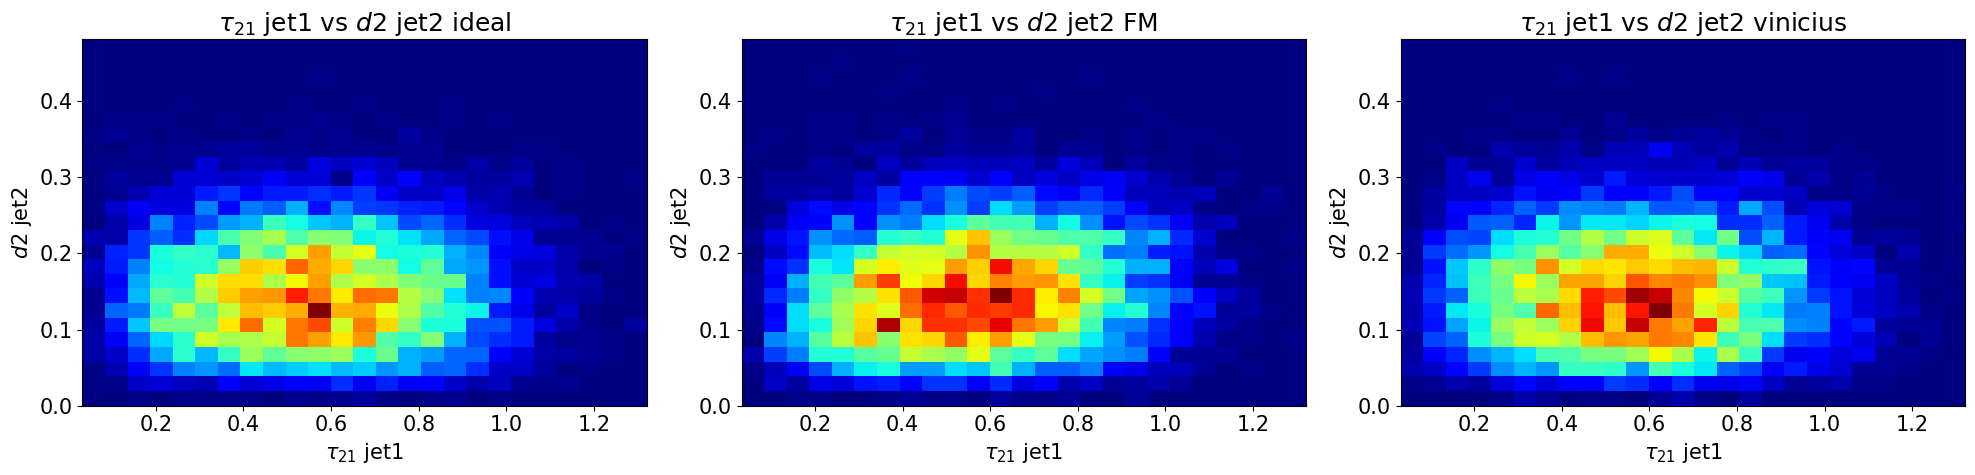

In [92]:
data_x = [tau21_id1, tau21_c1, tau21_v1]
data_y = [d2_id2, d2_c2, d2_v2]
label = ["ideal", "FM", "vinicius"]
quantity1 = r"$\tau_{21}$ jet1"
quantity2 = r"$d2$ jet2"
min_bin_x, max_bin_x = min(np.min(data_x[0]), np.min(data_x[1]), np.min(data_x[2])), max(np.max(data_x[0]), np.max(data_x[1]), np.max(data_x[2]))
min_bin_y, max_bin_y = min(np.min(data_y[0]), np.min(data_y[1]), np.min(data_y[2])), max(np.max(data_y[0]), np.max(data_y[1]), np.max(data_y[2]))
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.hist2d(data_x[i], data_y[i], bins=25, cmap="jet", range=[[min_bin_x, max_bin_x], [min_bin_y, max_bin_y]])
    ax.set_xlabel(f"{quantity1}")
    ax.set_ylabel(f"{quantity2}")
    ax.set_title(f"{quantity1} vs {quantity2} {label[i]}")
plt.tight_layout()
plt.show()

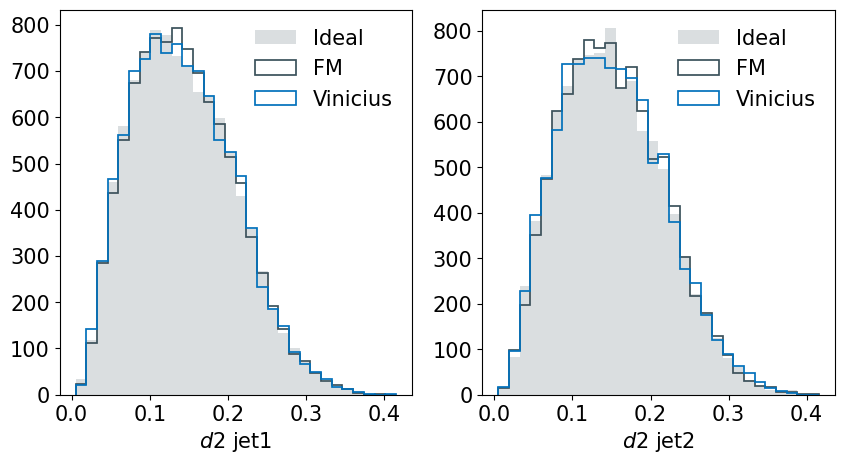

In [93]:
min_bin, max_bin = min(np.min(d2_id1), np.min(d2_c1), np.min(d2_v1)), max(np.max(d2_id1), np.max(d2_c1), np.max(d2_v1))
min_bin1, max_bin2 = min(np.min(d2_id2), np.min(d2_c2), np.min(d2_v2)), max(np.max(d2_id2), np.max(d2_c2), np.max(d2_v2))

bins = 30
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(d2_id1, bins=bins, alpha=0.5, label="Ideal", range=(min_bin, max_bin))
axs[0].hist(d2_c1, bins=bins, label="FM", histtype="step", range=(min_bin, max_bin))
axs[0].hist(d2_v1, bins=bins, label="Vinicius", histtype="step", range=(min_bin, max_bin))
axs[0].legend(frameon=False)
axs[0].set_xlabel(r"$d2$ jet1")

axs[1].hist(d2_id2, bins=bins, alpha=0.5, label="Ideal", range=(min_bin, max_bin))
axs[1].hist(d2_c2, bins=bins, label="FM", histtype="step", range=(min_bin, max_bin))
axs[1].hist(d2_v2, bins=bins, label="Vinicius", histtype="step", range=(min_bin, max_bin))
axs[1].legend(frameon=False)
axs[1].set_xlabel(r"$d2$ jet2")
plt.show()

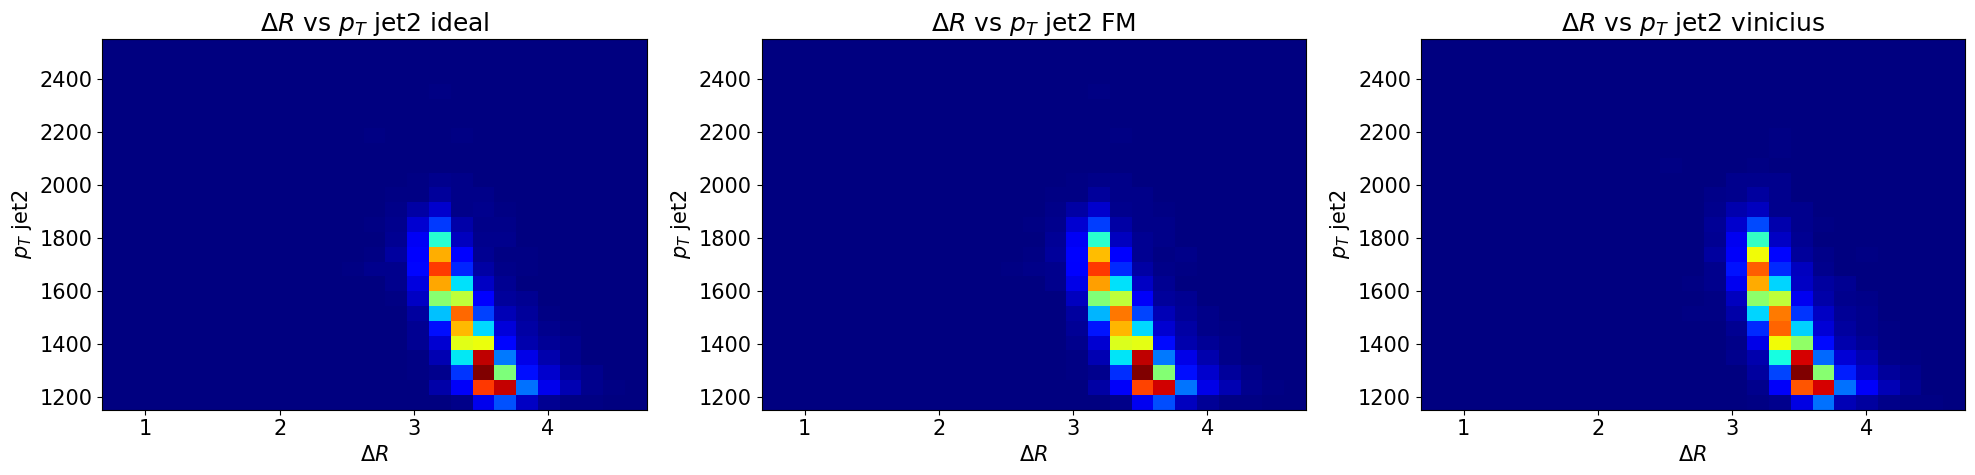

In [94]:
data_x = [deltaR_id_plot, deltaR_c_plot, deltaR_v_plot]
data_y = [pt_1_id_plot, pt_1_c_plot, pt_1_v_plot]
label = ["ideal", "FM", "vinicius"]
quantity1 = r"$\Delta R$"
quantity2 = r"$p_T$ jet2"
min_bin_x, max_bin_x = min(np.min(data_x[0]), np.min(data_x[1]), np.min(data_x[2])), max(np.max(data_x[0]), np.max(data_x[1]), np.max(data_x[2]))
min_bin_y, max_bin_y = min(np.min(data_y[0]), np.min(data_y[1]), np.min(data_y[2])), max(np.max(data_y[0]), np.max(data_y[1]), np.max(data_y[2]))
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.hist2d(data_x[i], data_y[i], bins=25, cmap="jet", range=[[min_bin_x, max_bin_x], [min_bin_y, max_bin_y]])
    ax.set_xlabel(f"{quantity1}")
    ax.set_ylabel(f"{quantity2}")
    ax.set_title(f"{quantity1} vs {quantity2} {label[i]}")
plt.tight_layout()
plt.show()

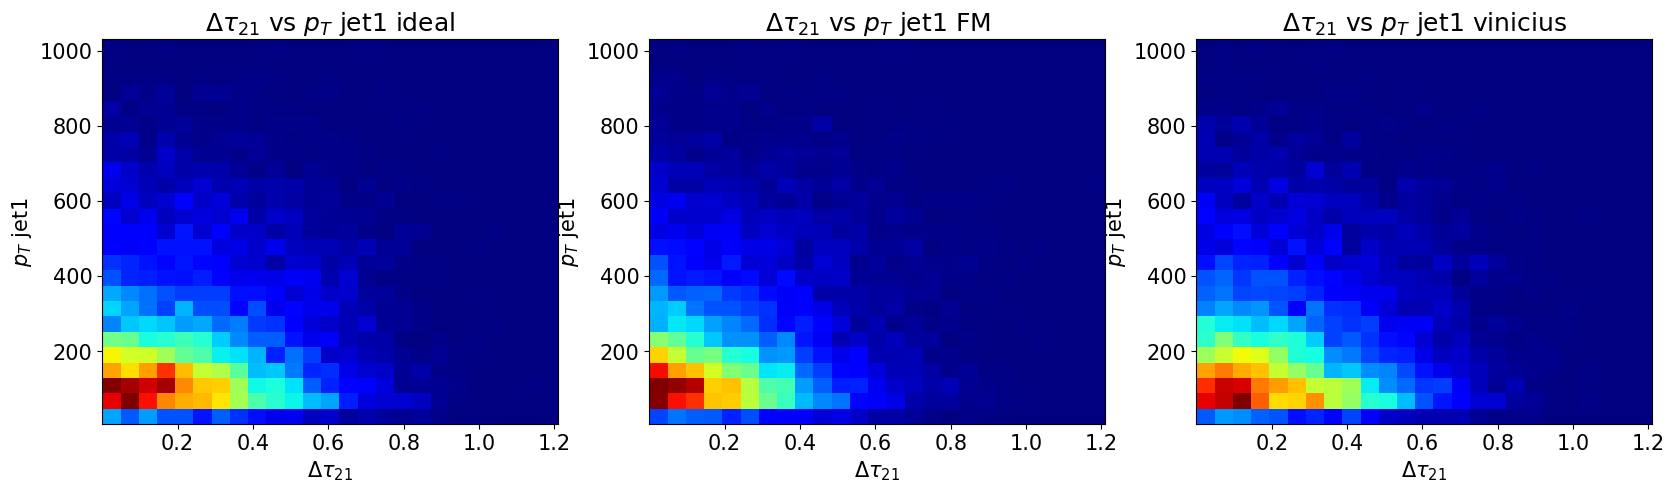

In [95]:
data_x = [delta_tau21_id, delta_tau21_c, delta_tau21_v]
data_y = [mass_1_id_plot, mass_1_c_plot, mass_1_v_plot]
label = ["ideal", "FM", "vinicius"]
quantity1 = r"$\Delta \tau_{21}$"
quantity2 = r"$p_T$ jet1"
min_bin_x, max_bin_x = min(np.min(data_x[0]), np.min(data_x[1]), np.min(data_x[2])), max(np.max(data_x[0]), np.max(data_x[1]), np.max(data_x[2]))
min_bin_y, max_bin_y = min(np.min(data_y[0]), np.min(data_y[1]), np.min(data_y[2])), max(np.max(data_y[0]), np.max(data_y[1]), np.max(data_y[2]))
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.hist2d(data_x[i], data_y[i], bins=25, cmap="jet", range=[[min_bin_x, max_bin_x], [min_bin_y, max_bin_y]])
    ax.set_xlabel(f"{quantity1}")
    ax.set_ylabel(f"{quantity2}")
    ax.set_title(f"{quantity1} vs {quantity2} {label[i]}")
plt.show()

## correlation plots

In [96]:
print(tau21_c1.shape)
print(tau21_c2.shape)
print(delta_pt_jet_c_plot.shape)
print(deltaR_c_plot.shape)
print(calc_mjj_c_plot.shape)
print(calc_jet_features_c_plot.shape)

(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000, 2, 4)


In [116]:
#names_list = ["tau21_1", "tau21_2", "tau32_1", "tau32_2", "d2_1", "d2_2", "delta_tau21", "delta_tau32", "delta_d2", "delta_pt_jet", "deltaR", "mjj", "mass_1", "mass_2", "pt_1", "pt_2", "eta_1", "eta_2", "phi_1", "phi_2"]
names_list = [r"$\tau_{21,1}$", r"$\tau_{21,2}$", r"$\tau_{32,1}$", r"$\tau_{32,2}$", r"$d_{2,1}$", r"$d_{2,2}$", r"$\Delta \tau_{21}$", r"$\Delta \tau_{32}$", r"$\Delta d_2$", r"$\Delta p_T$", r"$\Delta R$", r"$m_{jj}$", "$m_1$", "$m_2$", "$p_{T,1}$", "$p_{T,2}$", "$\eta_1$", "$\eta_2$", "$\phi_1$", "$\phi_2$", "$N_1$", "$N_2$"]
data_list_id = [tau21_id1, tau21_id2, tau32_id1, tau32_id2, d2_id1, d2_id2, delta_tau21_id, delta_tau32_id, delta_d2_id, delta_pt_jet_id_plot, deltaR_id_plot, calc_mjj_id_plot, mass_1_id_plot, mass_2_id_plot, pt_1_id_plot, pt_2_id_plot, eta_1_id_plot, eta_2_id_plot, phi_1_id_plot, phi_2_id_plot, multiplicity_1_id_plot, multiplicity_2_id_plot]
data_list_c = [tau21_c1, tau21_c2, tau32_c1, tau32_c2, d2_c1, d2_c2, delta_tau21_c, delta_tau32_c, delta_d2_c, delta_pt_jet_c_plot, deltaR_c_plot, calc_mjj_c_plot, mass_1_c_plot, mass_2_c_plot, pt_1_c_plot, pt_2_c_plot, eta_1_c_plot, eta_2_c_plot, phi_1_c_plot, phi_2_c_plot, multiplicity_1_c_plot, multiplicity_2_c_plot]
data_list_v = [tau21_v1, tau21_v2, tau32_v1, tau32_v2, d2_v1, d2_v2, delta_tau21_v, delta_tau32_v, delta_d2_v, delta_pt_jet_v_plot, deltaR_v_plot, calc_mjj_v_plot, mass_1_v_plot, mass_2_v_plot, pt_1_v_plot, pt_2_v_plot, eta_1_v_plot, eta_2_v_plot, phi_1_v_plot, phi_2_v_plot, multiplicity_1_v_plot, multiplicity_2_v_plot]

In [141]:
names_list = [r"$\tau_{21,1}$", r"$\tau_{21,2}$", "$m_1^{gen}$", "$m_2^{gen}$", "$p_{T,1}^{gen}$", "$p_{T,2}^{gen}$", "$\eta_1^{gen}$", "$\eta_2^{gen}$", "$\phi_1^{gen}$", "$\phi_2^{gen}$", "$N_1^{gen}$", "$N_2^{gen}$","$m_1^{cond}$", "$m_2^{cond}$", "$p_{T,1}^{cond}$", "$p_{T,2}^{cond}$", "$\eta_1^{cond}$", "$\eta_2^{cond}$", "$\phi_1^{cond}$", "$\phi_2^{cond}$", "$N_1^{cond}$", "$N_2^{cond}$" ]
data_list_id = [tau21_id1, tau21_id2, mass_1_id_plot, mass_2_id_plot, pt_1_id_plot, pt_2_id_plot, eta_1_id_plot, eta_2_id_plot, phi_1_id_plot, phi_2_id_plot, multiplicity_1_id_plot, multiplicity_2_id_plot, mass_1_id_plot_cond, mass_2_id_plot_cond, pt_1_id_plot_cond, pt_2_id_plot_cond, eta_1_id_plot_cond, eta_2_id_plot_cond, phi_1_id_plot_cond, phi_2_id_plot_cond, multiplicity_1_id_plot_cond, multiplicity_2_id_plot_cond]
data_list_c = [tau21_c1, tau21_c2, mass_1_c_plot, mass_2_c_plot, pt_1_c_plot, pt_2_c_plot, eta_1_c_plot, eta_2_c_plot, phi_1_c_plot, phi_2_c_plot, multiplicity_1_c_plot, multiplicity_2_c_plot, mass_1_c_plot_cond, mass_2_c_plot_cond, pt_1_c_plot_cond, pt_2_c_plot_cond, eta_1_c_plot_cond, eta_2_c_plot_cond, phi_1_c_plot_cond, phi_2_c_plot_cond, multiplicity_1_c_plot_cond, multiplicity_2_c_plot_cond]
data_list_v = [tau21_v1, tau21_v2, mass_1_v_plot, mass_2_v_plot, pt_1_v_plot, pt_2_v_plot, eta_1_v_plot, eta_2_v_plot, phi_1_v_plot, phi_2_v_plot, multiplicity_1_v_plot, multiplicity_2_v_plot, mass_1_v_plot_cond, mass_2_v_plot_cond, pt_1_v_plot_cond, pt_2_v_plot_cond, eta_1_v_plot_cond, eta_2_v_plot_cond, phi_1_v_plot_cond, phi_2_v_plot_cond, multiplicity_1_v_plot_cond, multiplicity_2_v_plot_cond]

In [142]:
df_data = pd.DataFrame(data=np.vstack(data_list_id).transpose(), columns=names_list)
correlations_full = df_data.corr()
upper_triangle = np.ones((len(names_list),len(names_list)))
upper_triangle[np.triu_indices(len(names_list),1)] = 0.0
correlations = correlations_full.mask(upper_triangle == 0)

Text(0.5, 1.0, 'Ideal')

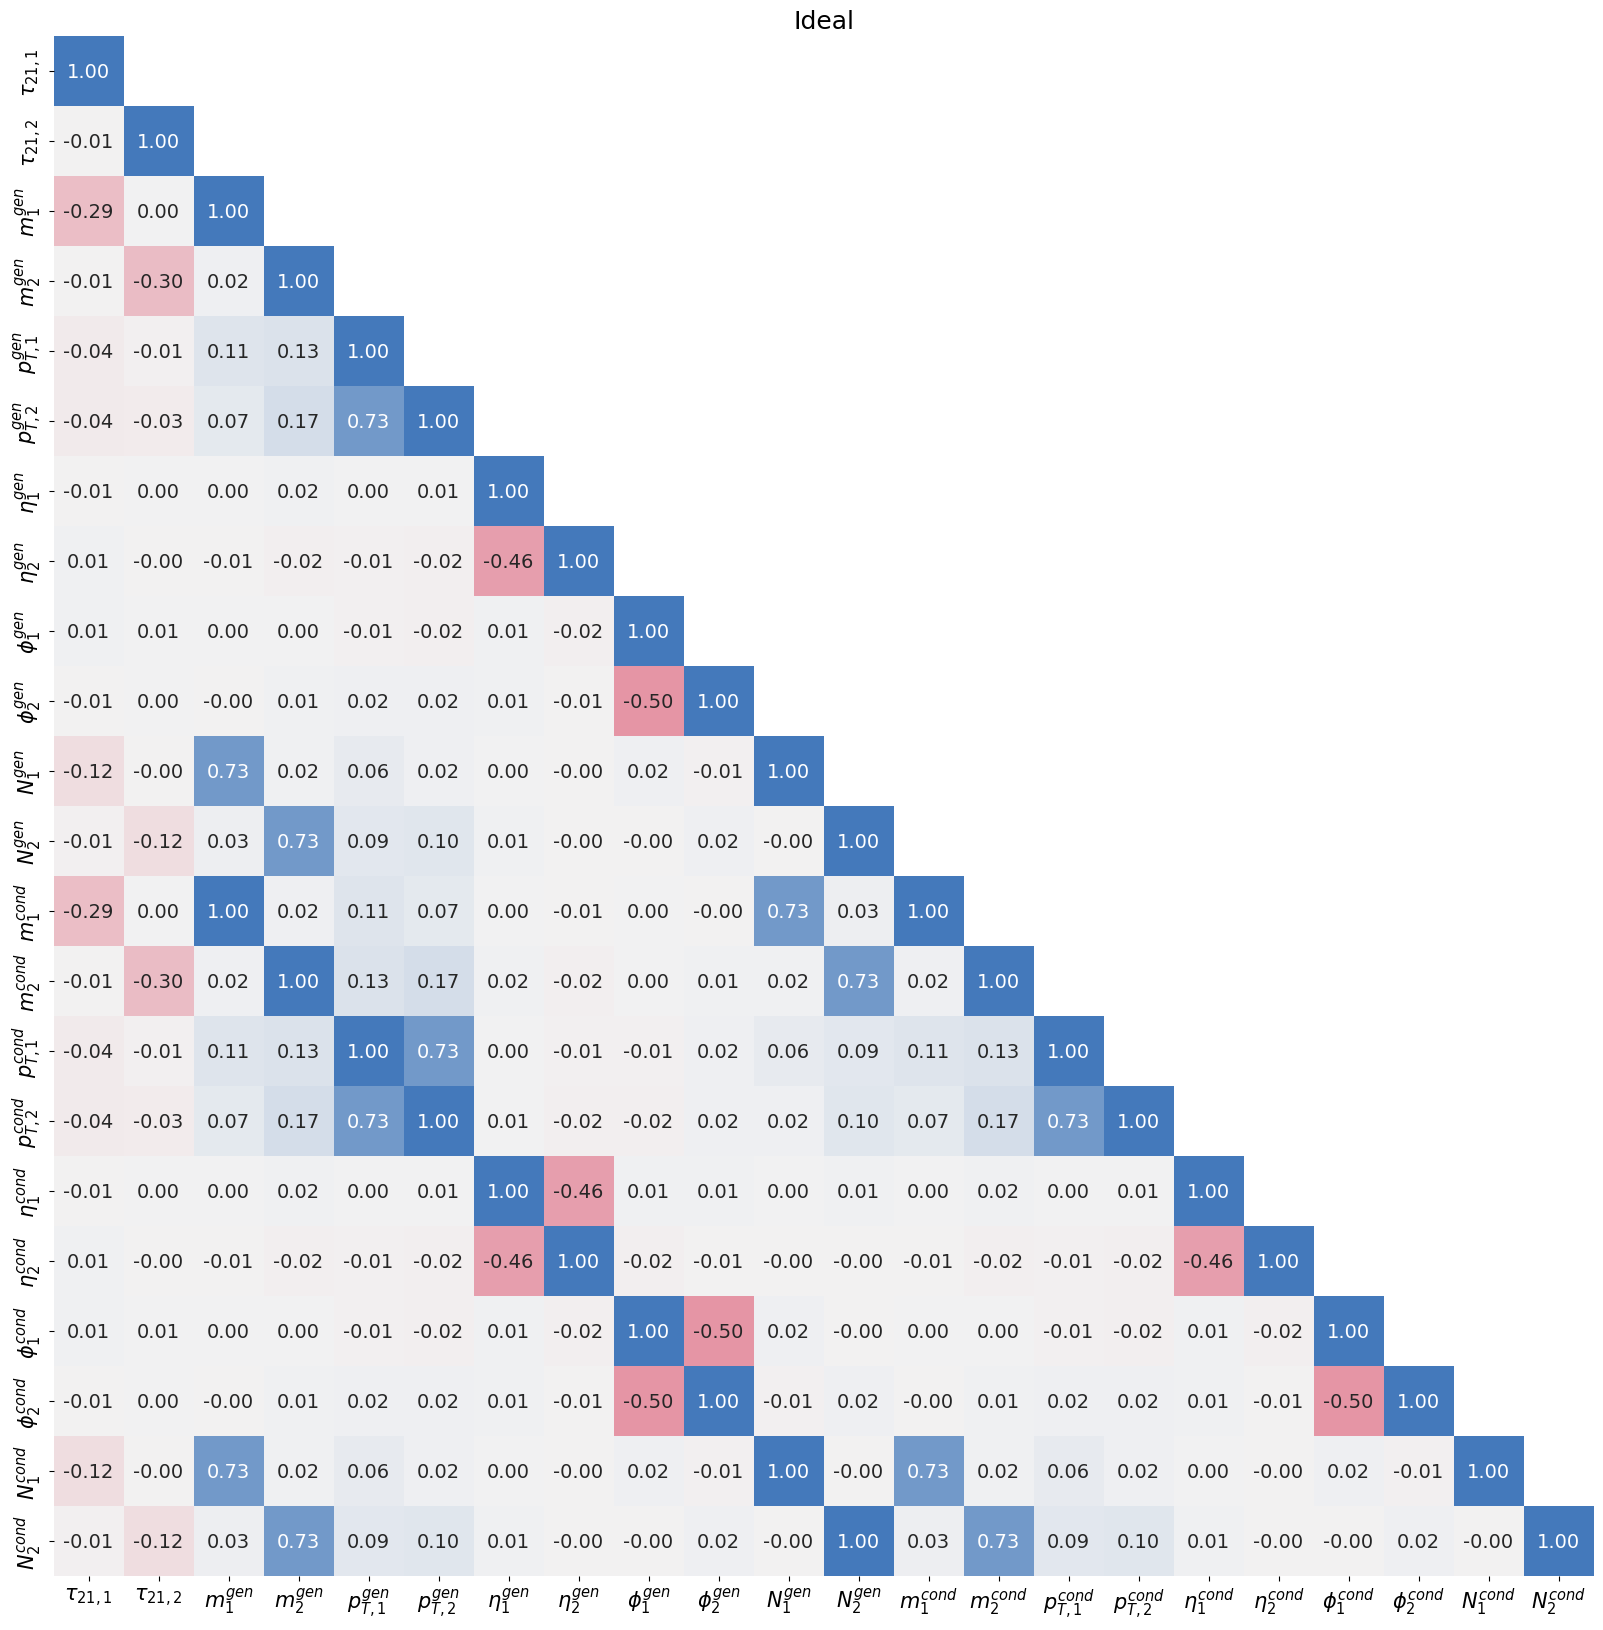

In [143]:
fig_cor = plt.figure(figsize=(20, 20))
ax_cor = fig_cor.add_subplot(1,1,1)
g = sns_plot = sns.heatmap((correlations),
        xticklabels=correlations.columns,
        yticklabels=correlations.index,
        cmap=sns.diverging_palette(5, 250, as_cmap=True),
        annot=True, ax=ax_cor, vmin=-1, vmax=1,
        annot_kws={"size": 14}, fmt=".2f", square=True, cbar=False, linewidths=0, linecolor='black'
        )
plt.title("Ideal")

In [144]:
df_data_c = pd.DataFrame(data=np.vstack(data_list_c).transpose(), columns=names_list)
correlations_full_c = df_data_c.corr()
upper_triangle_c = np.ones((len(names_list),len(names_list)))
upper_triangle_c[np.triu_indices(len(names_list),1)] = 0.0
correlations_c = correlations_full_c.mask(upper_triangle_c == 0)

Text(0.5, 1.0, 'FM')

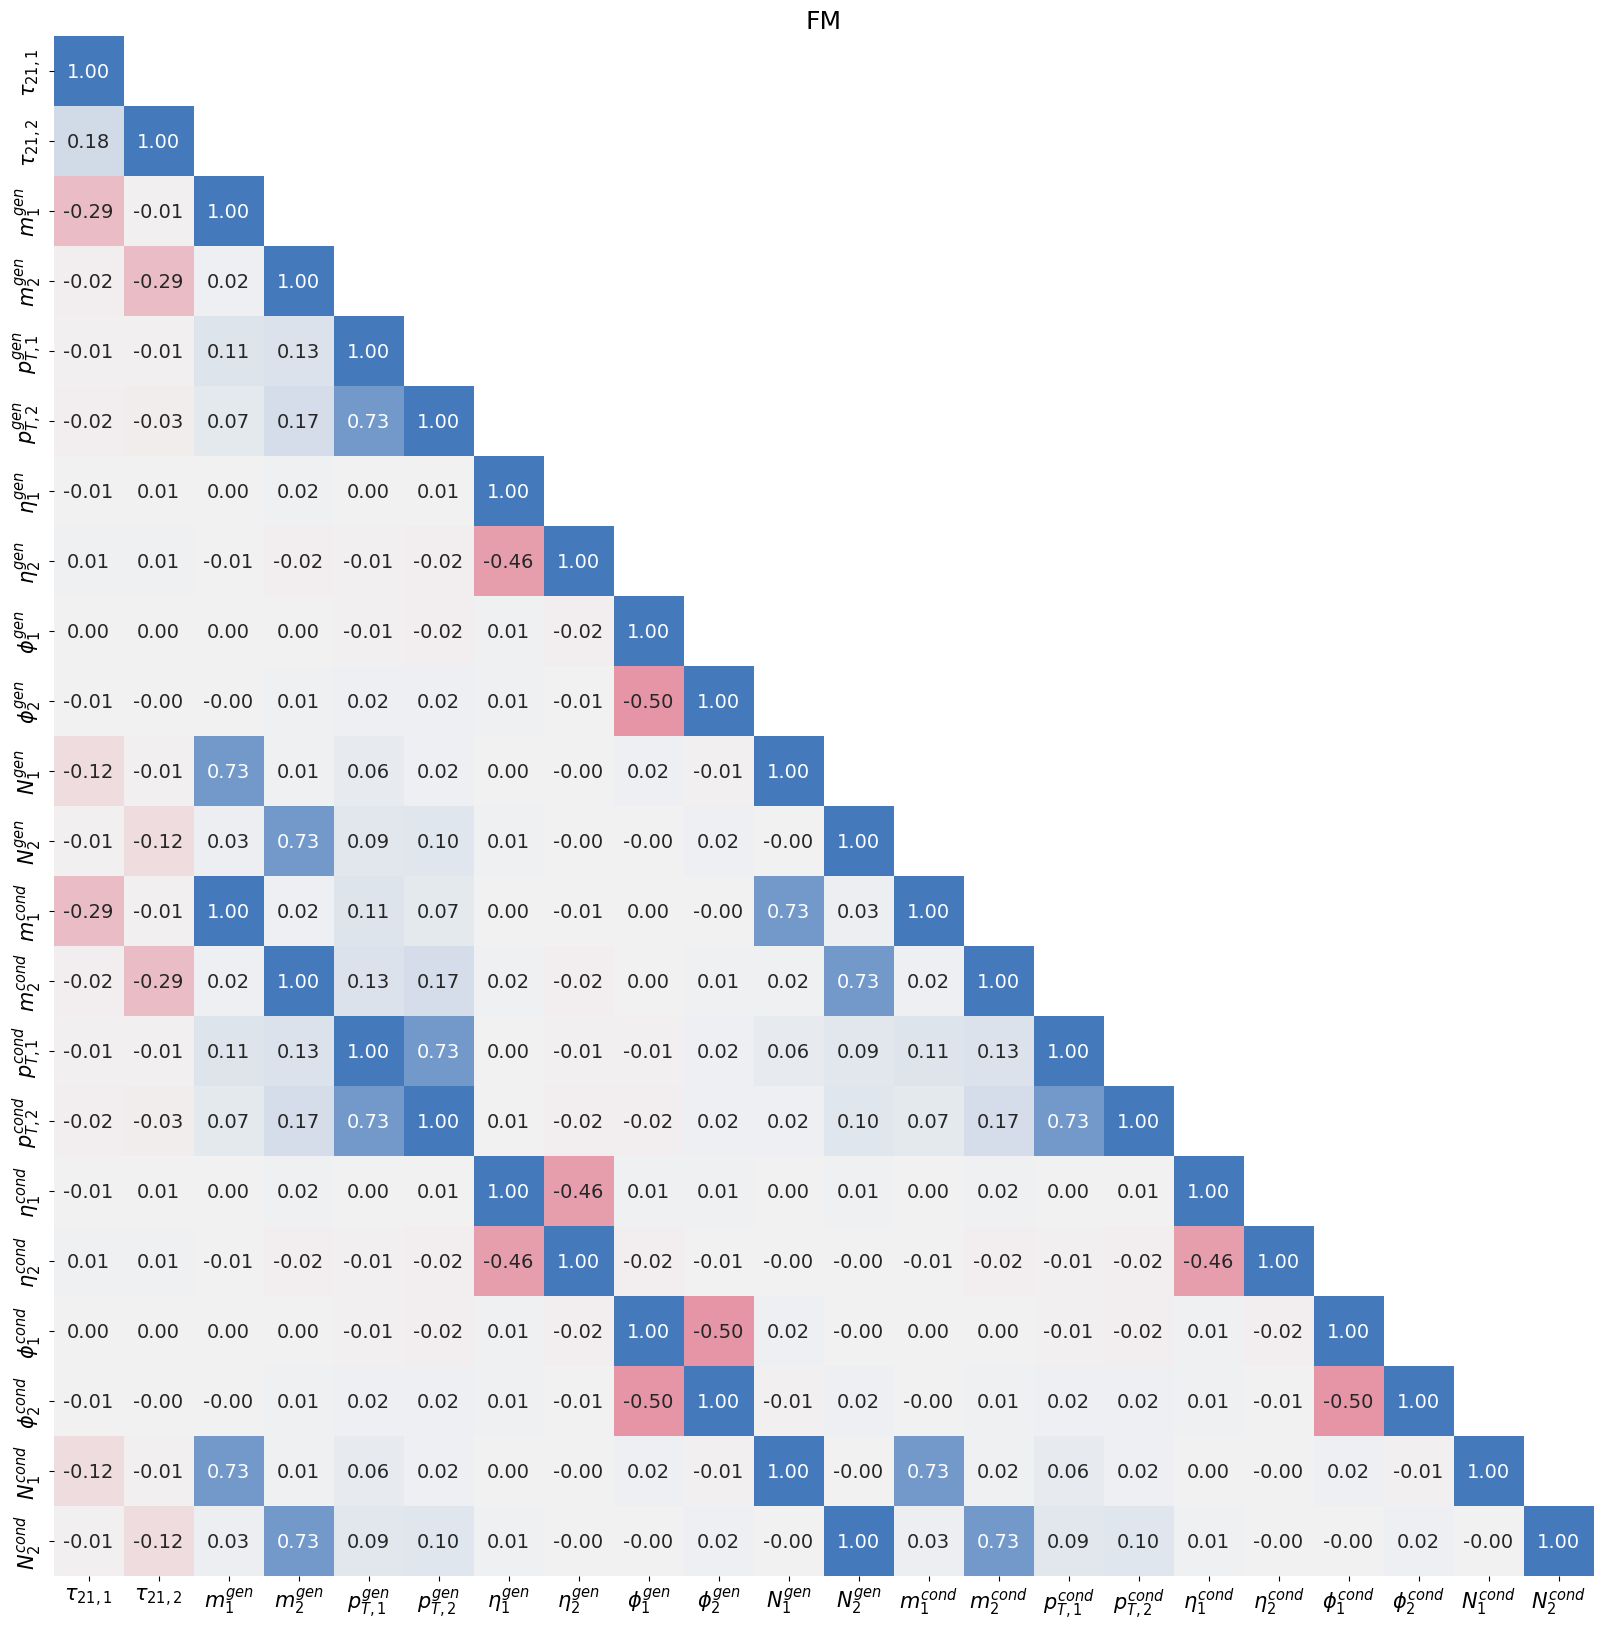

In [145]:
fig_cor_c = plt.figure(figsize=(20, 20))
ax_cor_c = fig_cor_c.add_subplot(1,1,1)
g_c = sns_plot_c = sns.heatmap((correlations_c),
        xticklabels=correlations_c.columns,
        yticklabels=correlations_c.index,
        cmap=sns.diverging_palette(5, 250, as_cmap=True),
        annot=True, ax=ax_cor_c, vmin=-1, vmax=1,
        annot_kws={"size": 14}, fmt=".2f", square=True, cbar=False, linewidths=0, linecolor='black'
        )
plt.title("FM")

In [146]:
df_data_v = pd.DataFrame(data=np.vstack(data_list_v).transpose(), columns=names_list)
correlations_full_v = df_data_v.corr()
upper_triangle_v = np.ones((len(names_list),len(names_list)))
upper_triangle_v[np.triu_indices(len(names_list),1)] = 0.0
correlations_v = correlations_full_v.mask(upper_triangle_v == 0)

Text(0.5, 1.0, 'Vinicius')

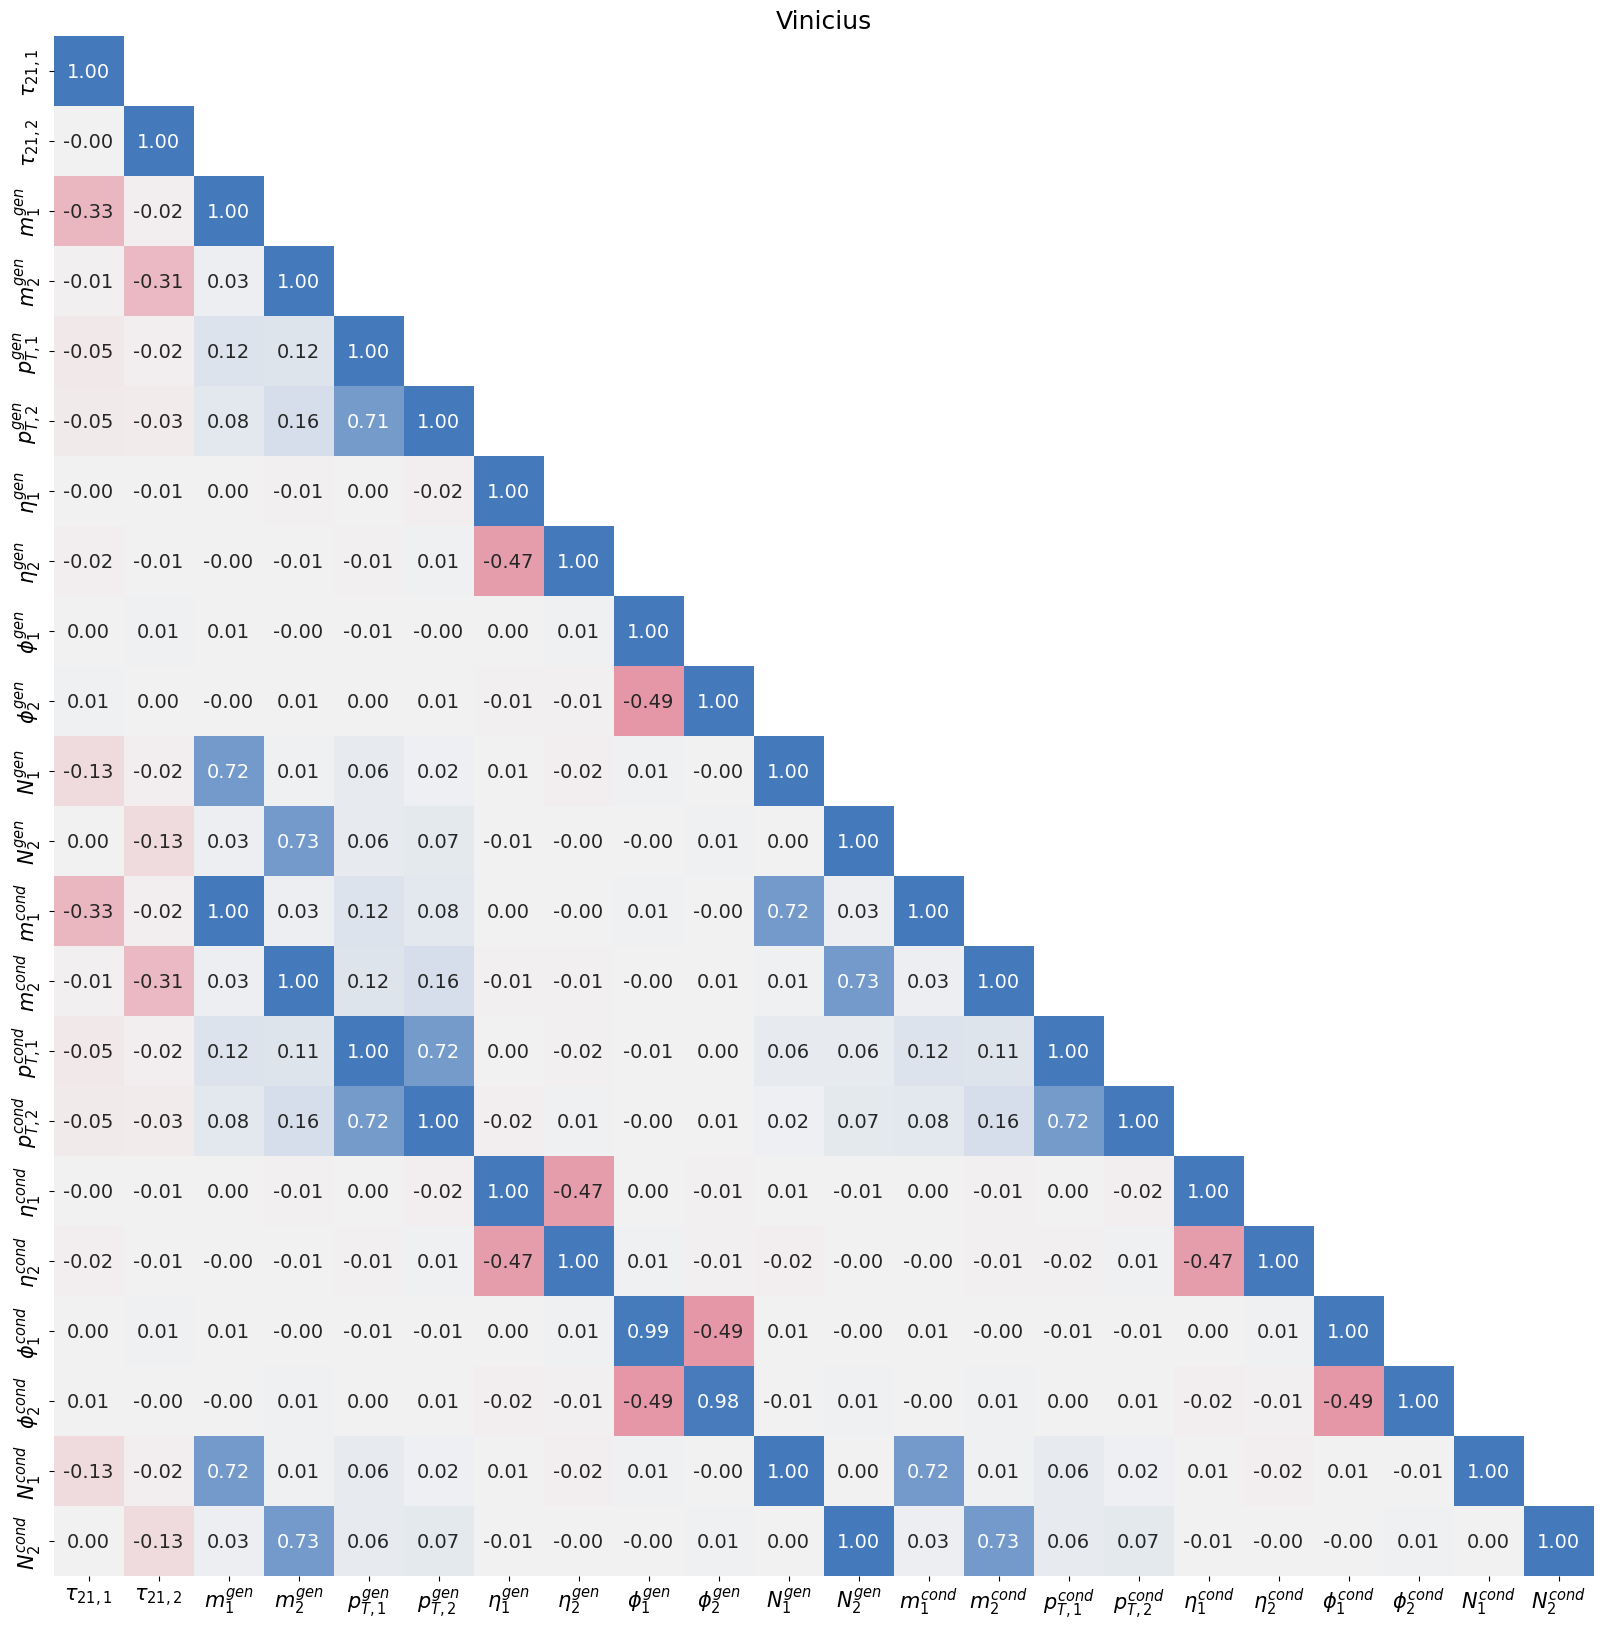

In [147]:
fig_cor_v = plt.figure(figsize=(20, 20))
ax_cor_v = fig_cor_v.add_subplot(1,1,1)
g_v = sns_plot_v = sns.heatmap((correlations_v),
        xticklabels=correlations_v.columns,
        yticklabels=correlations_v.index,
        cmap=sns.diverging_palette(5, 250, as_cmap=True),
        annot=True, ax=ax_cor_v, vmin=-1, vmax=1,
        annot_kws={"size": 14}, fmt=".2f", square=True, cbar=False, linewidths=0, linecolor='black'
        )
plt.title("Vinicius")

Text(0.5, 1.0, 'Correlation difference between ideal and FM')

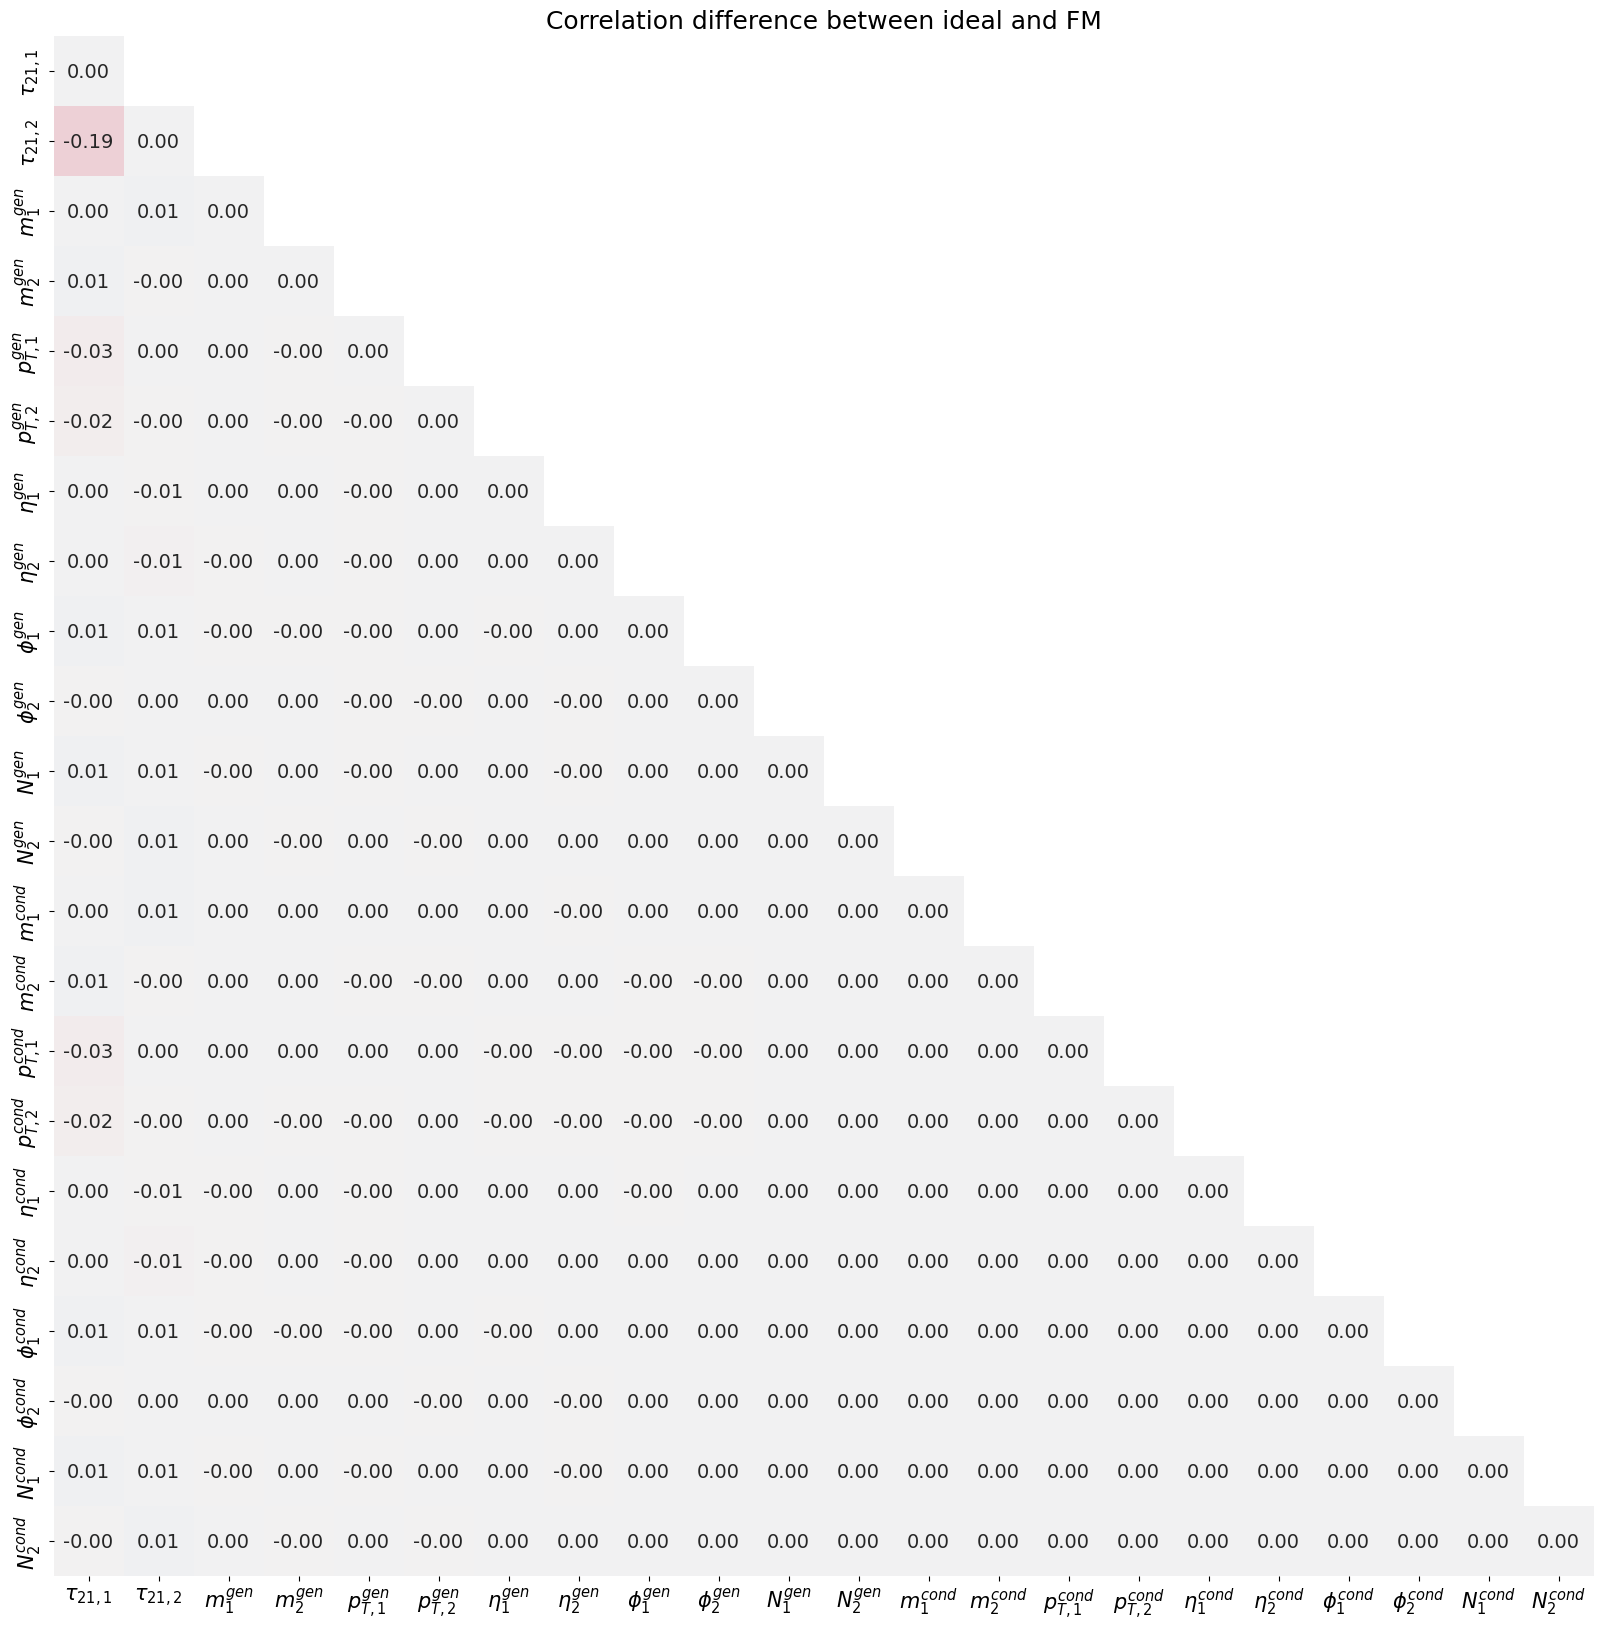

In [148]:
correlations_diff = correlations - correlations_c
fig_cor_diff = plt.figure(figsize=(20, 20))
ax_cor_diff = fig_cor_diff.add_subplot(1,1,1)
g_diff = sns_plot_diff = sns.heatmap((correlations_diff),
        xticklabels=correlations_diff.columns,
        yticklabels=correlations_diff.index,
        cmap=sns.diverging_palette(5, 250, as_cmap=True),
        annot=True, ax=ax_cor_diff, vmin=-1, vmax=1,
        annot_kws={"size": 14}, fmt=".2f", square=True, cbar=False, linewidths=0, linecolor='black'
        )
plt.title("Correlation difference between ideal and FM")

Text(0.5, 1.0, 'Correlation difference between ideal and Vincius')

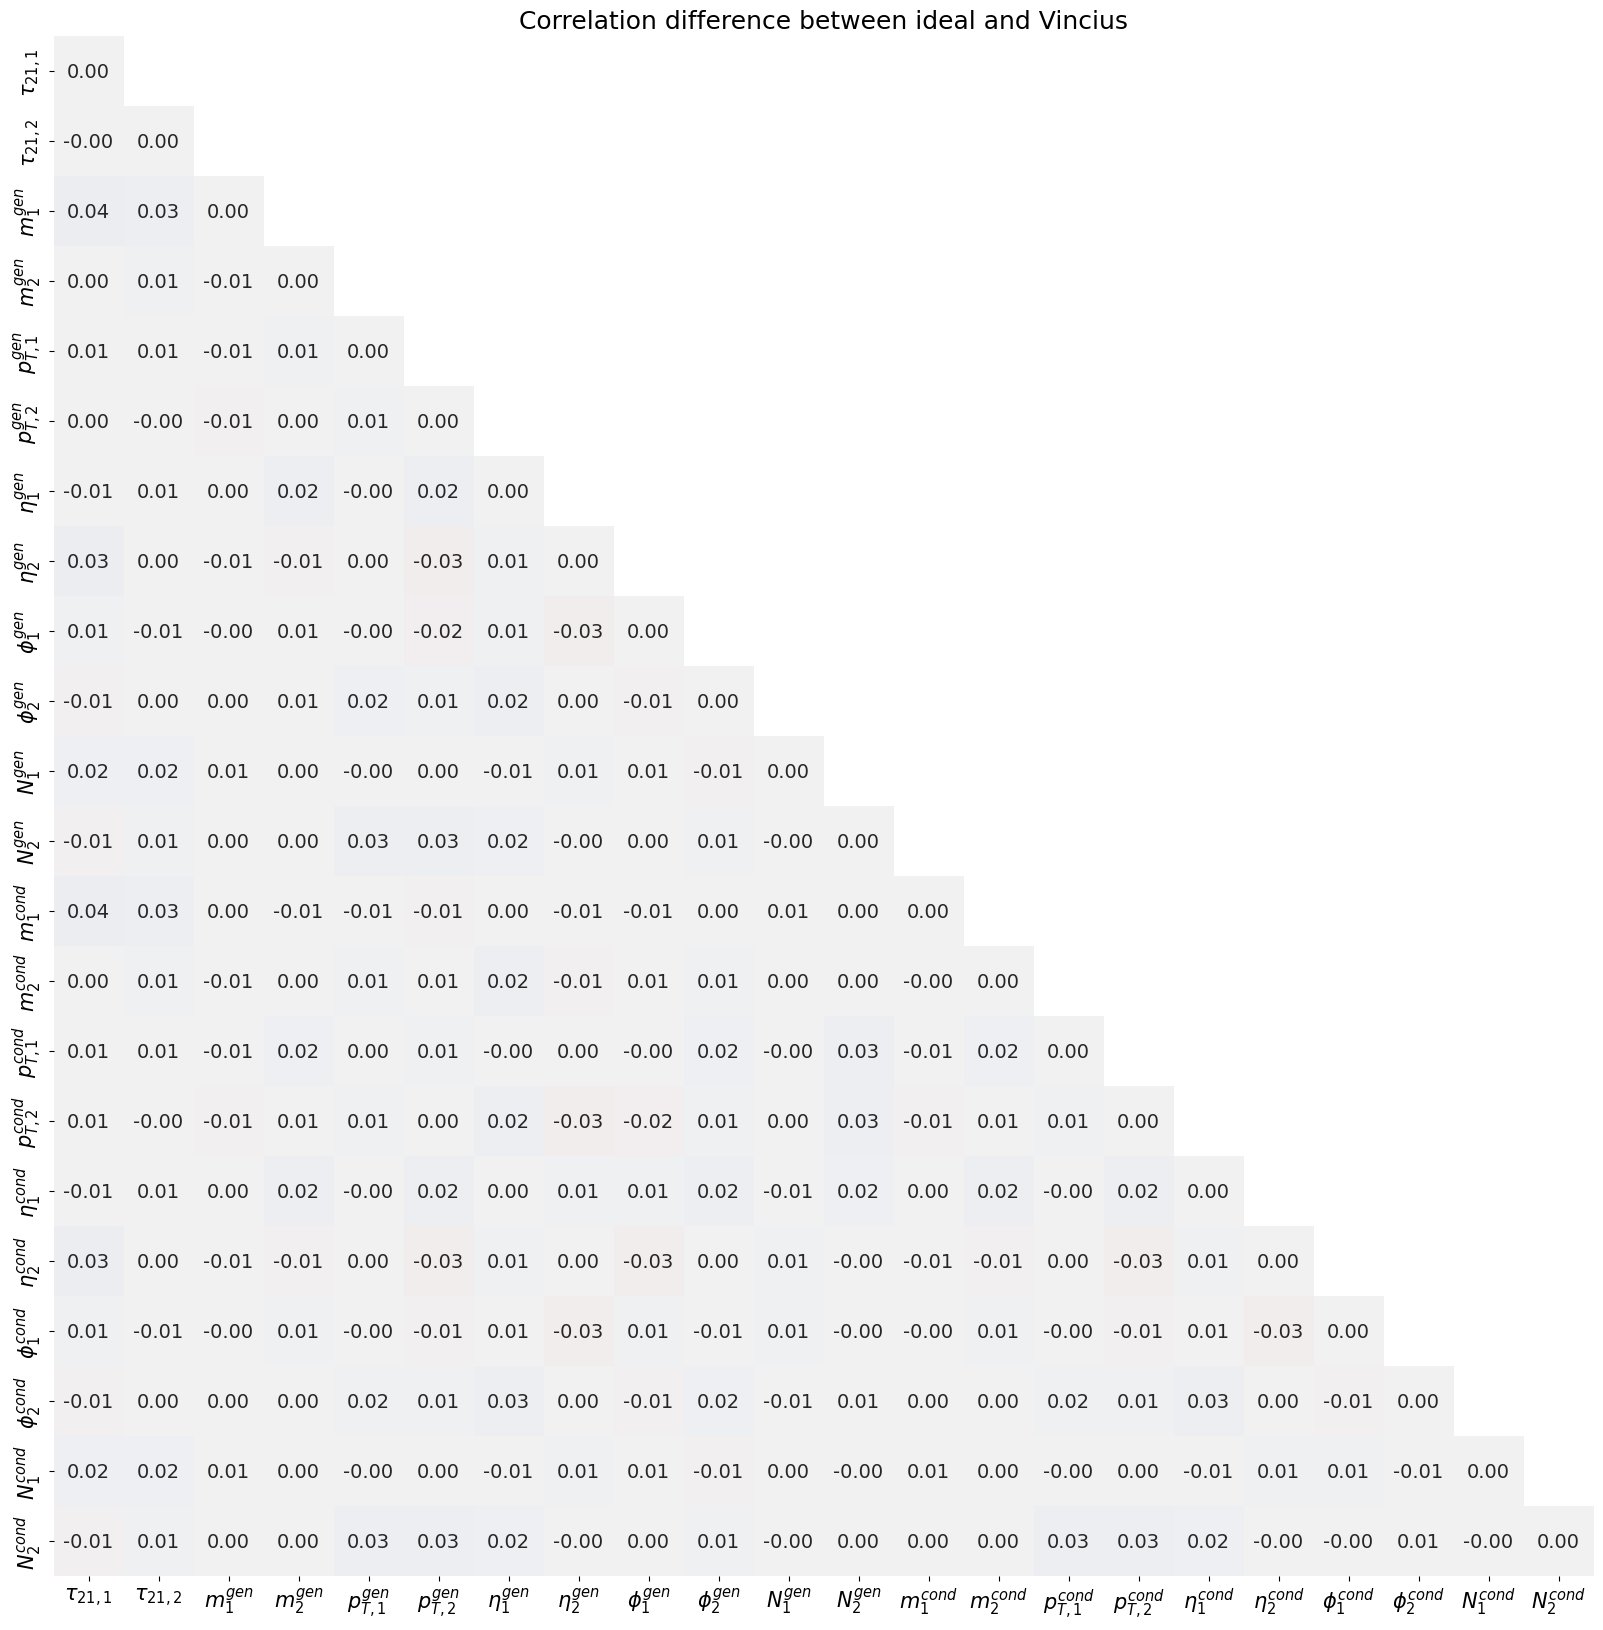

In [149]:
correlations_diff_v = correlations - correlations_v
fig_cor_diff_v = plt.figure(figsize=(20, 20))
ax_cor_diff_v = fig_cor_diff_v.add_subplot(1,1,1)
g_diff_v = sns_plot_diff_v = sns.heatmap((correlations_diff_v),
        xticklabels=correlations_diff_v.columns,
        yticklabels=correlations_diff_v.index,
        cmap=sns.diverging_palette(5, 250, as_cmap=True),
        annot=True, ax=ax_cor_diff_v, vmin=-1, vmax=1,
        annot_kws={"size": 14}, fmt=".2f", square=True, cbar=False, linewidths=0, linecolor='black'
        )
plt.title("Correlation difference between ideal and Vincius")

## substructure

In [20]:
from matplotlib.gridspec import GridSpec
def plot_single_jets(
    data: np.ndarray,
    color: str = "#E2001A",
    save_folder: str = "logs/",
    save_name: str = "sim_jets",
    title: str = "Simulated Jets",
) -> plt.figure:
    """Create a plot with 16 randomly selected jets from the data.

    Args:
        data (_type_): Data to plot.
        color (str, optional): Color of plotted point cloud. Defaults to "#E2001A".
        save_folder (str, optional): Path to folder where the plot is saved. Defaults to "logs/".
        save_name (str, optional): File_name for saving the plot. Defaults to "sim_jets".
    """
    mask_data = np.ma.masked_where(
        data[:, :, 0] == 0,
        data[:, :, 0],
    )
    mask = np.expand_dims(mask_data, axis=-1)
    fig = plt.figure(figsize=(5, 5))
    gs = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0])
    for i in range(10):

        idx = np.random.randint(len(data))
        x_plot = data[idx, :, :2]  # .cpu()
        s_plot = np.abs(data[idx, :, 2])  # .cpu())
        #s_plot[mask[idx, :, 0] < 0.0] = 0.0

        ax.scatter(*x_plot.T, s=5000 * s_plot, color=color, alpha=0.5)

    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(title)

    #plt.show()
    #plt.tight_layout()

    #plt.savefig(f"{save_folder}{save_name}.png", bbox_inches="tight")
    return fig

In [21]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
def plot_single_jets2(
    data: np.ndarray,
    color: str = "#E2001A",
    save_folder: str = "logs/",
    save_name: str = "sim_jets",
    title: str = "Simulated Jets",
) -> plt.figure:
    """Create a plot with 16 randomly selected jets from the data.

    Args:
        data (_type_): Data to plot.
        color (str, optional): Color of plotted point cloud. Defaults to "#E2001A".
        save_folder (str, optional): Path to folder where the plot is saved. Defaults to "logs/".
        save_name (str, optional): File_name for saving the plot. Defaults to "sim_jets".
    """
    mask_data = np.ma.masked_where(
        data[:, :, 0] == 0,
        data[:, :, 0],
    )
    mask = np.expand_dims(mask_data, axis=-1)
    fig = plt.figure(figsize=(5, 5))
    gs = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0])
    #for i in range(10):

    #idx = np.random.randint(len(data))
    x_plot = data[:, :, :2]  # .cpu()
    s_plot = np.abs(data[:, :, 2])  # .cpu())
    #s_plot[mask[idx, :, 0] < 0.0] = 0.0


    ax.hist2d(x_plot[:,:,0].flatten(),x_plot[:,:,1].flatten(),weights=s_plot.flatten(),bins=100, norm = LogNorm())
    #ax.scatter(*x_plot.T, s=5000 * s_plot, color=color, alpha=0.5)
    #ax.loglog()
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")

    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    ax.set_title(title)

    #plt.show()
    #plt.tight_layout()

    #plt.savefig(f"{save_folder}{save_name}.png", bbox_inches="tight")
    return fig

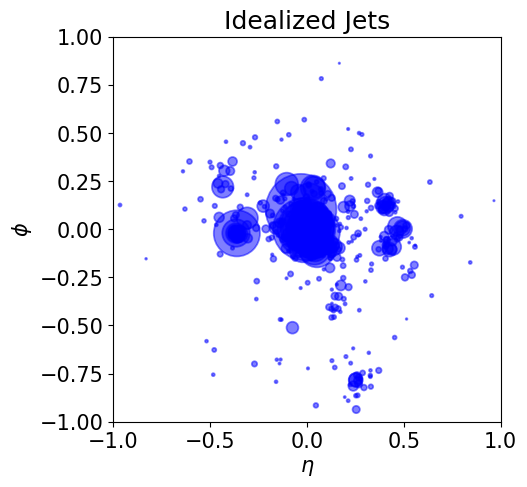

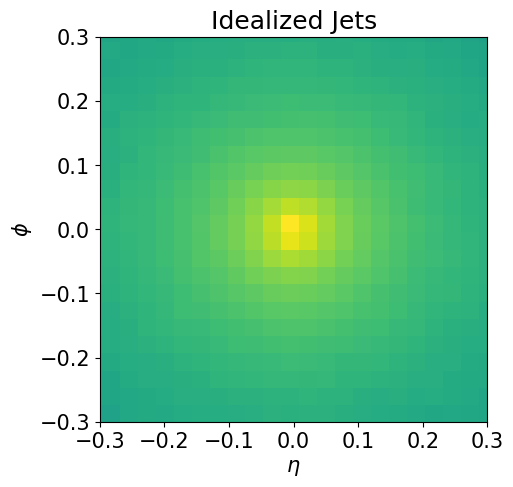

In [22]:
t = plot_single_jets(particle_data_id[:,0][...,[1,2,0]], color="blue", title="Idealized Jets")
t = plot_single_jets2(particle_data_id[:,0][...,[1,2,0]], color="blue", title="Idealized Jets")

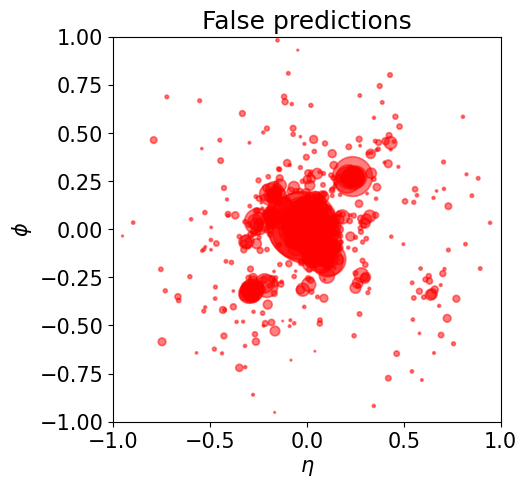

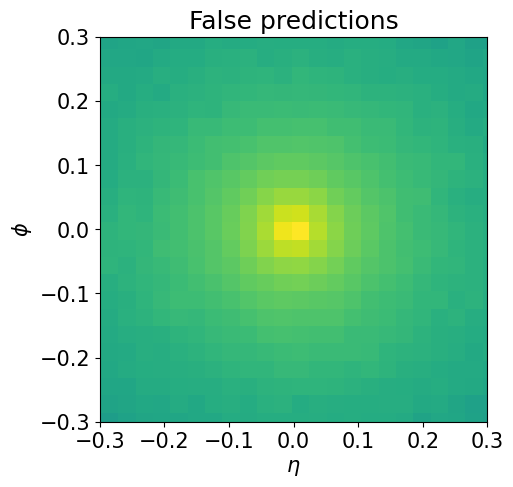

In [23]:
t = plot_single_jets(false_p[:,0][...,[1,2,0]], color="red", title="False predictions")
t = plot_single_jets2(false_p[:,0][...,[1,2,0]], color="red", title="False predictions")


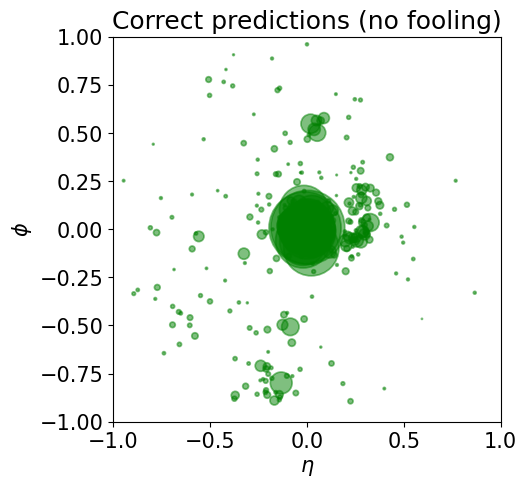

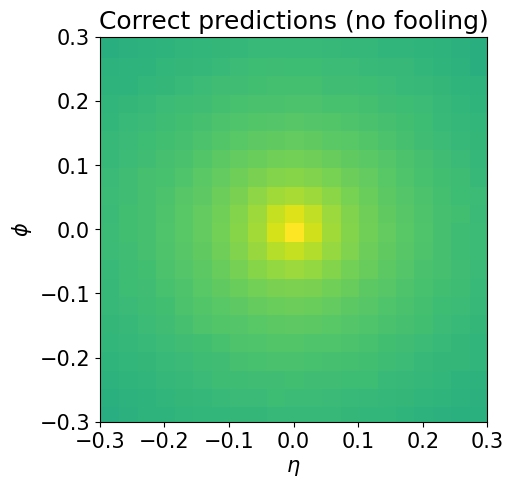

In [24]:
t = plot_single_jets(correct_p[:,0][...,[1,2,0]], color="green", title="Correct predictions (no fooling)")
t = plot_single_jets2(correct_p[:,0][...,[1,2,0]], color="green", title="Correct predictions (no fooling)")

## substructure 

In [28]:
dump_hlvs(
    np.reshape(correct_p[...,[1,2,0]],(-1, correct_p.shape[-2], correct_p.shape[-1]), order="F")[
        :10000
    ],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_correct",
    plot=False,
)

Computing substructure variables:  93%|█████████▎| 9286/10000 [01:59<00:11, 60.27it/s] /home/ewencedr/deep-learning/notebooks/../src/utils/jet_substructure.py:497: RuntimeWarning: invalid value encountered in double_scalars
  d2s.append((ecf3 * sum_pt) / (ecf2**2))
Computing substructure variables: 100%|██████████| 10000/10000 [02:08<00:00, 78.10it/s]


In [29]:
dump_hlvs(
    np.reshape(false_p[...,[1,2,0]],(-1, false_p.shape[-2], false_p.shape[-1]), order="F")[
        :10000
    ],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_false",
    plot=False,
)

Computing substructure variables: 100%|██████████| 10000/10000 [02:34<00:00, 64.79it/s]


In [30]:
dump_hlvs(
    np.reshape(particle_data_id[...,[1,2,0]],(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), order="F")[
        :10000
    ],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_id2",
    plot=False,
)

Computing substructure variables: 100%|██████████| 10000/10000 [02:10<00:00, 76.85it/s]


In [101]:
# load substructure for id data
data_substructure_id = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_id2" + ".h5", "r") as f:
    tau21_jetnet = np.array(f["tau21"])
    tau32_jetnet = np.array(f["tau32"])
    d2_jetnet = np.array(f["d2"])
    for key in f.keys():
        data_substructure_id.append(np.array(f[key]))
data_substructure_jetnet = np.array(data_substructure_id)

In [102]:
# load substructure for model generated data
keys = []
data_substructure_c = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_correct" + ".h5", "r") as f:
    tau21_c = np.array(f["tau21"])
    tau32_c = np.array(f["tau32"])
    d2_c = np.array(f["d2"])
    for key in f.keys():
        keys.append(key)
        data_substructure_c.append(np.array(f[key]))
keys = np.array(keys)
data_substructure_c = np.array(data_substructure_c)

In [103]:
# load substructure for model generated data
keys = []
data_substructure_f = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_false" + ".h5", "r") as f:
    tau21_f = np.array(f["tau21"])
    tau32_f = np.array(f["tau32"])
    d2_f = np.array(f["d2"])
    for key in f.keys():
        keys.append(key)
        data_substructure_f.append(np.array(f[key]))
keys = np.array(keys)
data_substructure_f = np.array(data_substructure_f)

In [34]:
# calculate wasserstein distances
w_dist_tau21_mean, w_dist_tau21_std = wasserstein_distance_batched(
    tau21_jetnet, tau21_jetnet, num_eval_samples=50_000, num_batches=40
)
w_dist_tau32_mean, w_dist_tau32_std = wasserstein_distance_batched(
    tau32_jetnet, tau32_jetnet, num_eval_samples=50_000, num_batches=40
)
w_dist_d2_mean, w_dist_d2_std = wasserstein_distance_batched(
    d2_jetnet, d2_jetnet, num_eval_samples=50_000, num_batches=40
)
print(f"Wasserstein distance tau21: {w_dist_tau21_mean} +- {w_dist_tau21_std}")
print(f"Wasserstein distance tau32: {w_dist_tau32_mean} +- {w_dist_tau32_std}")
print(f"Wasserstein distance d2: {w_dist_d2_mean} +- {w_dist_d2_std}")

Wasserstein distance tau21: 0.0017178641820118665 +- 0.0006362643546821114
Wasserstein distance tau32: 0.0012157855973032425 +- 0.00037473175727038654
Wasserstein distance d2: 0.0005218936181690457 +- 0.00016976802670189646


In [37]:
# calculate wasserstein distances
w_dist_tau21_mean_c, w_dist_tau21_std_c = wasserstein_distance_batched(
    tau21_jetnet, tau21_c, num_eval_samples=50_000, num_batches=40
)
w_dist_tau32_mean_c, w_dist_tau32_std_c = wasserstein_distance_batched(
    tau32_jetnet, tau32_c, num_eval_samples=50_000, num_batches=40
)
w_dist_d2_mean_c, w_dist_d2_std_c = wasserstein_distance_batched(
    d2_jetnet, d2_c, num_eval_samples=50_000, num_batches=40
)
print(f"Wasserstein distance tau21: {w_dist_tau21_mean_c} +- {w_dist_tau21_std_c}")
print(f"Wasserstein distance tau32: {w_dist_tau32_mean_c} +- {w_dist_tau32_std_c}")
print(f"Wasserstein distance d2: {w_dist_d2_mean_c} +- {w_dist_d2_std_c}")

Wasserstein distance tau21: 0.011821570629670297 +- 0.0013975518440238492
Wasserstein distance tau32: 0.006124485702629602 +- 0.0008844768111137473
Wasserstein distance d2: nan +- nan


In [38]:
# calculate wasserstein distances
w_dist_tau21_mean_f, w_dist_tau21_std_f = wasserstein_distance_batched(
    tau21_jetnet, tau21_f, num_eval_samples=50_000, num_batches=40
)
w_dist_tau32_mean_f, w_dist_tau32_std_f = wasserstein_distance_batched(
    tau32_jetnet, tau32_f, num_eval_samples=50_000, num_batches=40
)
w_dist_d2_mean_f, w_dist_d2_std_f = wasserstein_distance_batched(
    d2_jetnet, d2_f, num_eval_samples=50_000, num_batches=40
)
print(f"Wasserstein distance tau21: {w_dist_tau21_mean_f} +- {w_dist_tau21_std_f}")
print(f"Wasserstein distance tau32: {w_dist_tau32_mean_f} +- {w_dist_tau32_std_f}")
print(f"Wasserstein distance d2: {w_dist_d2_mean_f} +- {w_dist_d2_std_f}")

Wasserstein distance tau21: 0.003947288056062757 +- 0.0005461575757841377
Wasserstein distance tau32: 0.0025286165175327094 +- 0.0005146788389572441
Wasserstein distance d2: 0.003936729315136211 +- 0.00023146437939632823


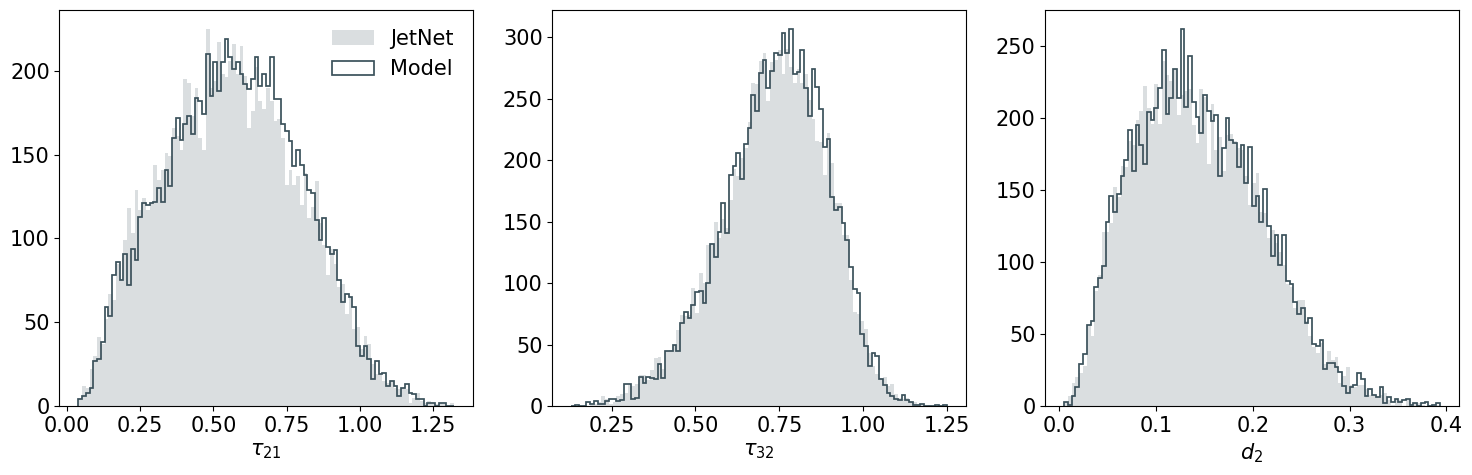

In [104]:
plot_substructure(
    tau21=tau21_c,
    tau32=tau32_c,
    d2=d2_c,
    tau21_jetnet=tau21_jetnet,
    tau32_jetnet=tau32_jetnet,
    d2_jetnet=d2_jetnet,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

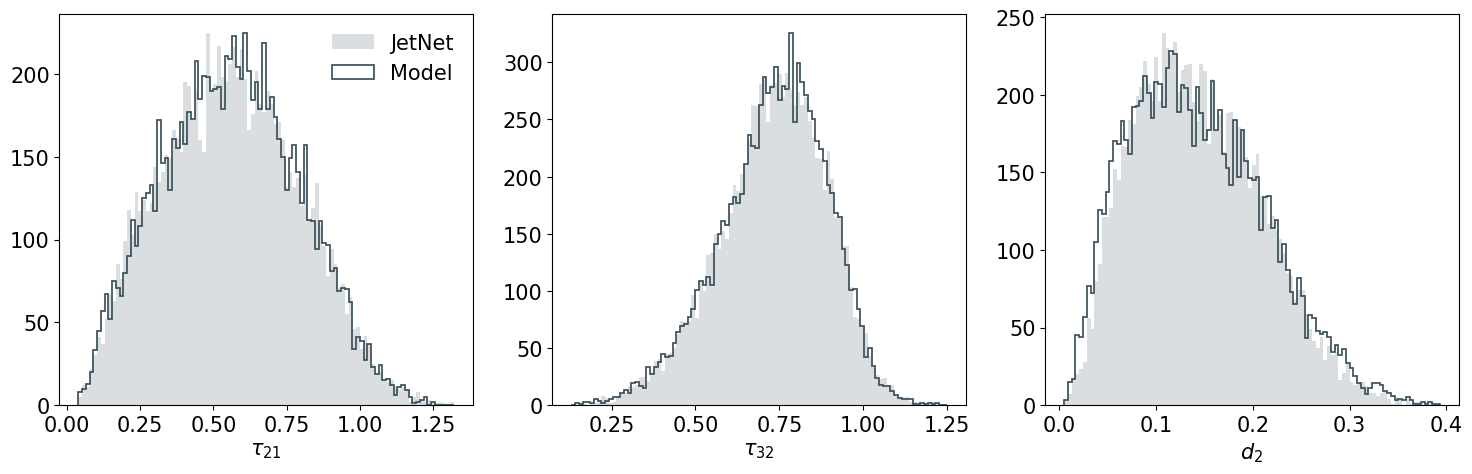

In [105]:
plot_substructure(
    tau21=tau21_f,
    tau32=tau32_f,
    d2=d2_f,
    tau21_jetnet=tau21_jetnet,
    tau32_jetnet=tau32_jetnet,
    d2_jetnet=d2_jetnet,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

In [ ]:
delta_tau21_id = 

## continue

In [58]:
#path_falseclassified = "/beegfs/desy/user/ewencedr/data/lhco/generated/falseclassified.h5"
#with h5py.File(path_falseclassified, "w") as f:
#    f.create_dataset("jet_features", data=false_j)
#    f.create_dataset("particle_features", data=false_p)
#    f.create_dataset("mjj", data=false_mjj)

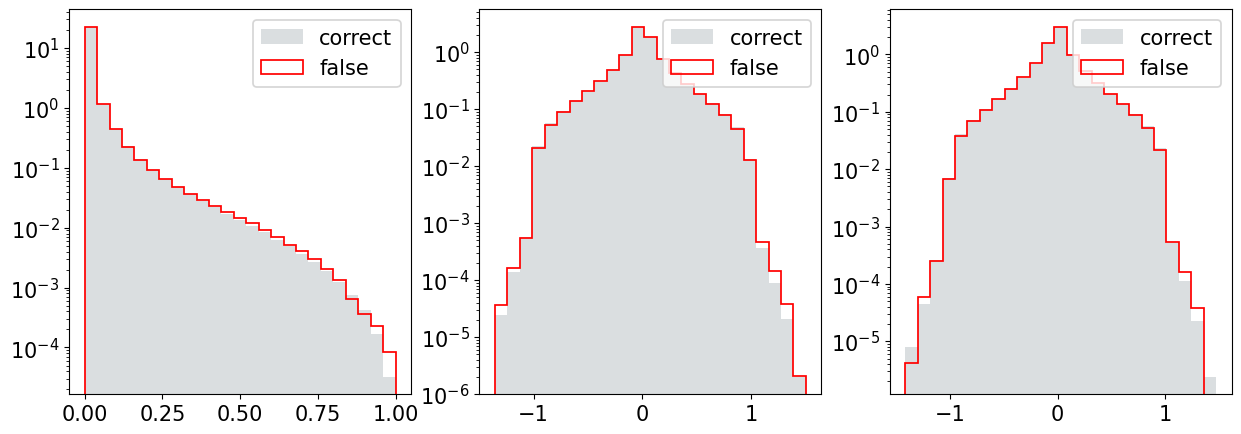

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(false_p[..., i]), np.min(correct_p[...,i])), max(np.max(false_p[..., i]), np.max(correct_p[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(correct_p[..., i].flatten()[correct_p[..., i].flatten() != 0], bins=bins, label="correct", alpha=0.5, density=True)
    hist2 = ax.hist(false_p[..., i].flatten()[false_p[..., i].flatten() != 0], bins=hist[1], label="false", histtype="step", color="red", density=True)
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

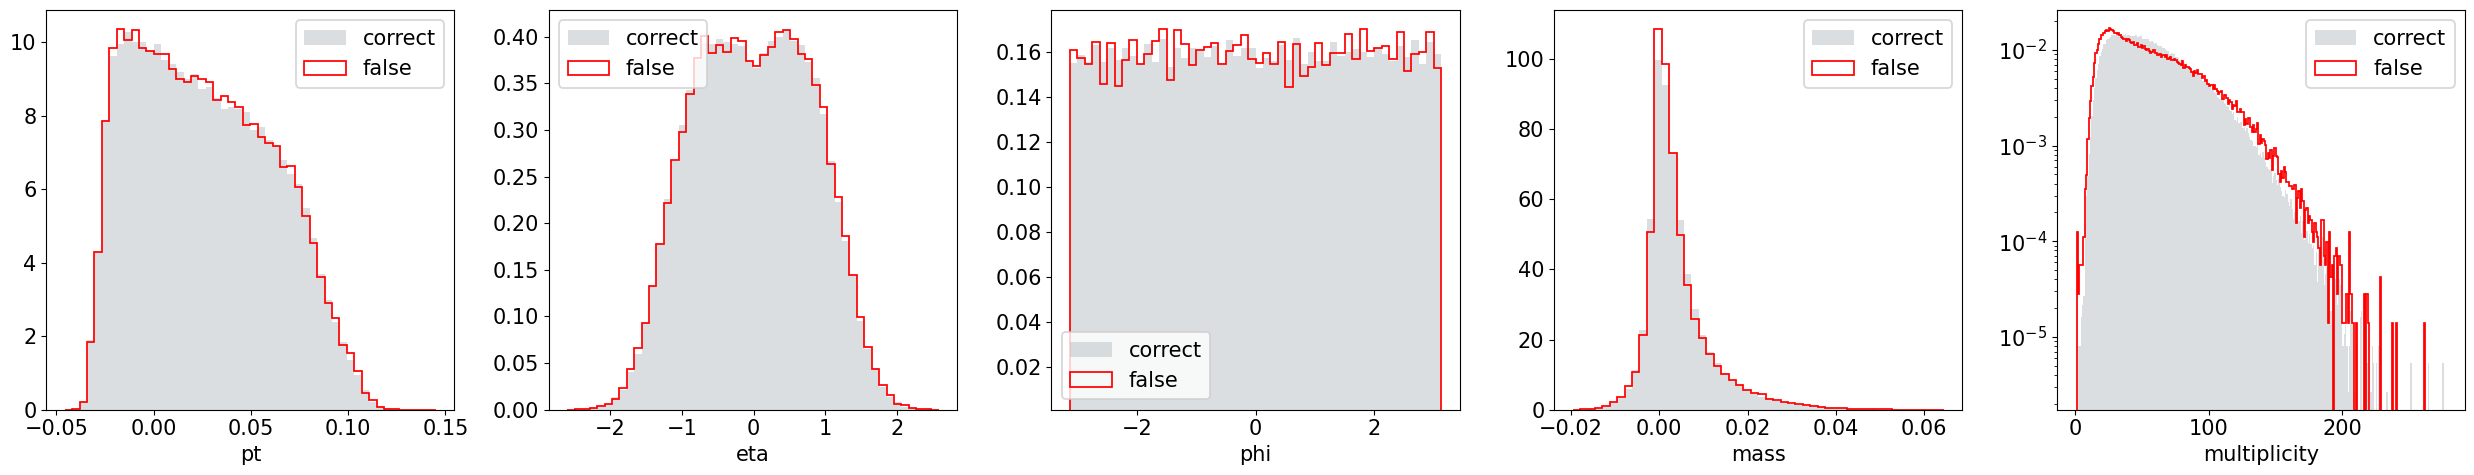

In [71]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(false_j[..., i]), np.min(correct_j[...,i])), max(np.max(false_j[..., i]), np.max(correct_j[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(correct_j[..., i].flatten()[correct_j[..., i].flatten() != 0], bins=bins, label="correct", alpha=0.5, density=True)
    hist2 = ax.hist(false_j[..., i].flatten()[false_j[..., i].flatten() != 0], bins=hist[1], label="false", histtype="step", color="red", density=True)
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

In [46]:
print(correct_p.shape)

(186590, 2, 279, 3)


In [47]:
#c_p = correct_p[:len(false_p)]
c_p = correct_p
correct_p_flat = c_p.reshape(c_p.shape[0]*c_p.shape[1], -1)
false_p_flat = false_p.reshape(false_p.shape[0]*false_p.shape[1], -1)

In [48]:
print(correct_p_flat.shape)
print(false_p_flat.shape)

(373180, 837)
(71522, 837)


In [ ]:
fig, axs = plt.subplots(93, 9, figsize=(45, 465))
for i, ax in enumerate(axs.flatten()):
    min_bin, max_bin = min(np.min(false_p_flat[..., i]), np.min(correct_p_flat[...,i])), max(np.max(false_p_flat[..., i]), np.max(correct_p_flat[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(correct_p_flat[...,i].flatten()[correct_p_flat[..., i].flatten() != 0], bins=bins, alpha=0.5, label="nofool", histtype="stepfilled", density=True, range=(min_bin, max_bin))
    ax.hist(false_p_flat[...,i].flatten()[false_p_flat[..., i].flatten() != 0], bins=hist[1], label="fool", histtype="step", density=True)
    #ax.hist(flat_data_v[...,i].flatten()[flat_data_v[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    #[false_p_flat[..., i].flatten() != 0]
    label=""
    if (i+1) % 3 == 1:
        label += " pt"
        ax.set_yscale("log")
        #print(min_bin, max_bin)
    if (i+1) % 3 == 2:
        label += " eta"
        #ax.set_yscale("log")
    if (i+1) % 3 == 0:
        label += " phi"
        #ax.set_yscale("log")
    #if i < flat_data_id.shape[-1]//2:
    #    label += " first jet"
    #else:
    #    label += " second jet"
    #ax.set_yscale("log")
    label += f"{(i//3)}"
    #for j in range(particle_data_id.shape[-2]):
    #    if (i+1) % ((j+1)*3) < 0:
    #        label += f" particle {i}"
    ax.set_xlabel(label)
    ax.legend()
plt.savefig("comparison_correctly_falsly_classified.pdf")
plt.tight_layout()
plt.show()

In [29]:
fig, axs = plt.subplots(93, 9, figsize=(45, 465))
for i, ax in enumerate(axs.flatten()):
    #min_bin, max_bin = min(np.min(false_p_flat[..., i]), np.min(correct_p_flat[...,i])), max(np.max(false_p_flat[..., i]), np.max(correct_p_flat[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=100
    hist = ax.hist(correct_p_flat[...,i].flatten()[np.allclose(correct_p_flat[..., i].flatten(),0)], bins=bins, alpha=0.5, label="nofool", histtype="stepfilled", density=True)
    ax.hist(false_p_flat[...,i].flatten()[np.allclose(false_p_flat[..., i].flatten(),0)], bins=hist[1], label="fool", histtype="step", density=True)
    #ax.hist(flat_data_v[...,i].flatten()[flat_data_v[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    #[false_p_flat[..., i].flatten() != 0]
    label=""
    if (i+1) % 3 == 1:
        label += " pt"
        ax.set_yscale("log")
        #print(min_bin, max_bin)
    if (i+1) % 3 == 2:
        label += " eta"
        #ax.set_yscale("log")
    if (i+1) % 3 == 0:
        label += " phi"
        #ax.set_yscale("log")
    #if i < flat_data_id.shape[-1]//2:
    #    label += " first jet"
    #else:
    #    label += " second jet"
    #ax.set_yscale("log")
    label += f"{(i//3)}"
    #for j in range(particle_data_id.shape[-2]):
    #    if (i+1) % ((j+1)*3) < 0:
    #        label += f" particle {i}"
    ax.set_xlabel(label)
    ax.legend()
plt.tight_layout()
plt.show()

/home/ewencedr/.conda/envs/pllhome/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


KeyboardInterrupt: 

# tests

In [27]:
path_gen = f"/beegfs/desy/user/ewencedr/data//lhco/generated/idealized_LHCO.h5"
with h5py.File(path_gen, "r") as f:
    jet_data_gen = f["jet_features"][:]
    particle_data_gen = f["particle_features"][:]

jet_data_gen = jet_data_gen[..., :4]
#particle_data_gen = particle_data_gen[..., [1, 2, 0]]

In [37]:
mask_gen = np.expand_dims(np.array(particle_data_gen[..., 0] != 0), axis=-1).astype(
    int
)

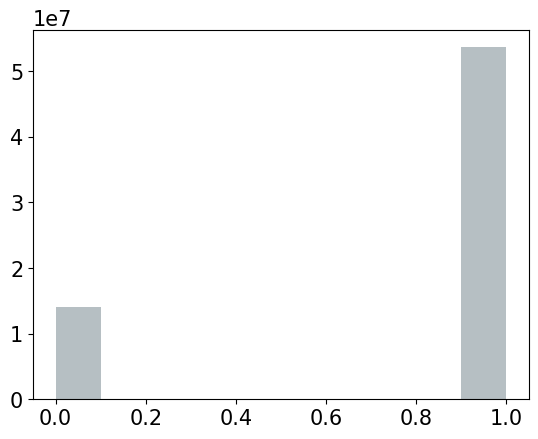

In [32]:
plt.hist(mask_gen.flatten())
plt.show()

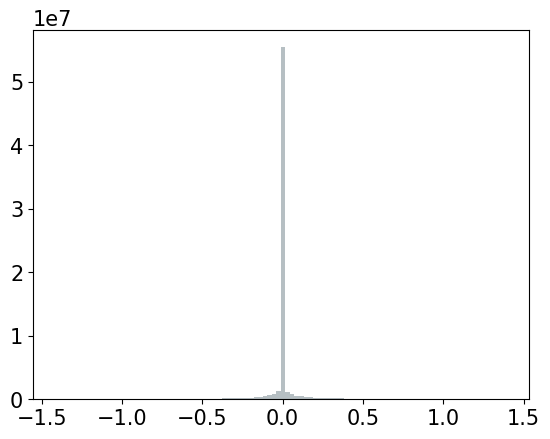

In [28]:
plt.hist(particle_data_gen[..., 2].flatten(), bins=100)
plt.show()

In [14]:
path_bckg = f"/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_background_rel.h5"

with h5py.File(path_bckg, "r") as f:
    jet_data_bckg = f["jet_data"][:]
    particle_data_bckg = f["constituents"][:]
    mask_bckg = f["mask"][:]

In [15]:
# cut mjj window
p4_jets_bckg = ef.p4s_from_ptyphims(jet_data_bckg)
# get mjj from p4_jets
sum_p4_bckg = p4_jets_bckg[:, 0] + p4_jets_bckg[:, 1]
mjj_bckg = ef.ms_from_p4s(sum_p4_bckg)

In [16]:
args_to_keep_bckg = (mjj_bckg > 3300) & (mjj_bckg < 3700)

In [17]:
jet_data_bckg = jet_data_bckg[args_to_keep_bckg]
particle_data_bckg = particle_data_bckg[args_to_keep_bckg]
mask_bckg = mask_bckg[args_to_keep_bckg]

In [23]:
print(len(jet_data_bckg))
print(len(particle_data_gen))

121351
121351


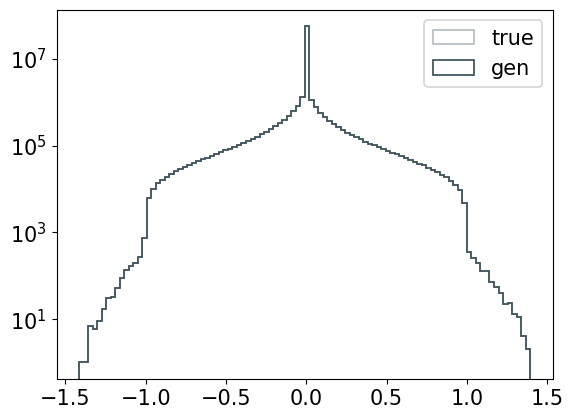

In [30]:
hist = plt.hist(particle_data_bckg[..., 2].flatten(), bins=100, histtype="step", label="true")
plt.hist(particle_data_gen[..., 2].flatten(), bins=100, histtype="step", label="gen")
plt.yscale("log")
plt.legend()
plt.show()

## compare idealized vs fm data

In [10]:
path_id = "/beegfs/desy/user/ewencedr/data/lhco/generated/idealized_LHCO.h5"
with h5py.File(path_id, "r") as f:
    jet_data_id = f["jet_features"][:]
    particle_data_id = f["particle_features"][:]

In [11]:
path_c = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-10layer-256latent-logpt-nnew_sr-midpoint-300.h5"
with h5py.File(path_c, "r") as f:
    jet_data_c = f["jet_features"][:]
    particle_data_c = f["particle_features"][:]

In [12]:
path_v = "/beegfs/desy/user/ewencedr/data/lhco/generated/FPCD_LHCO_SR.h5"
with h5py.File(path_v, "r") as f:
    jet_data_v = f["jet_features"][:]
    particle_data_v = f["particle_features"][:]
jet_data_v = jet_data_v[:len(jet_data_id)]
particle_data_v = particle_data_v[:len(particle_data_id)]

In [73]:
print(jet_data_id.shape)
print(jet_data_c.shape)
print(jet_data_v.shape)
print(particle_data_id.shape)
print(particle_data_c.shape)
print(particle_data_v.shape)

(121351, 2, 5)
(121351, 2, 5)
(121351, 2, 5)
(121351, 2, 279, 3)
(121351, 2, 279, 3)
(121351, 2, 279, 3)


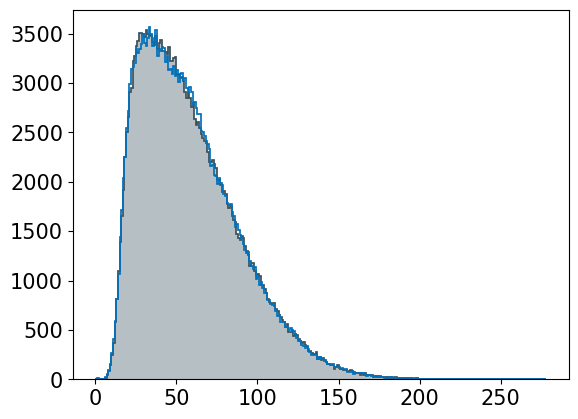

In [69]:
pm_calc = np.expand_dims(np.sum(particle_data_c[...,0] != 0, axis=-1),axis=-1)
bins = range(0, 279)
plt.hist(pm_calc.flatten(), bins=bins)
plt.hist(jet_data_id[...,4].flatten(), bins=bins, histtype="step")
plt.hist(jet_data_v[...,4].flatten(), bins=bins, histtype="step")
plt.show()

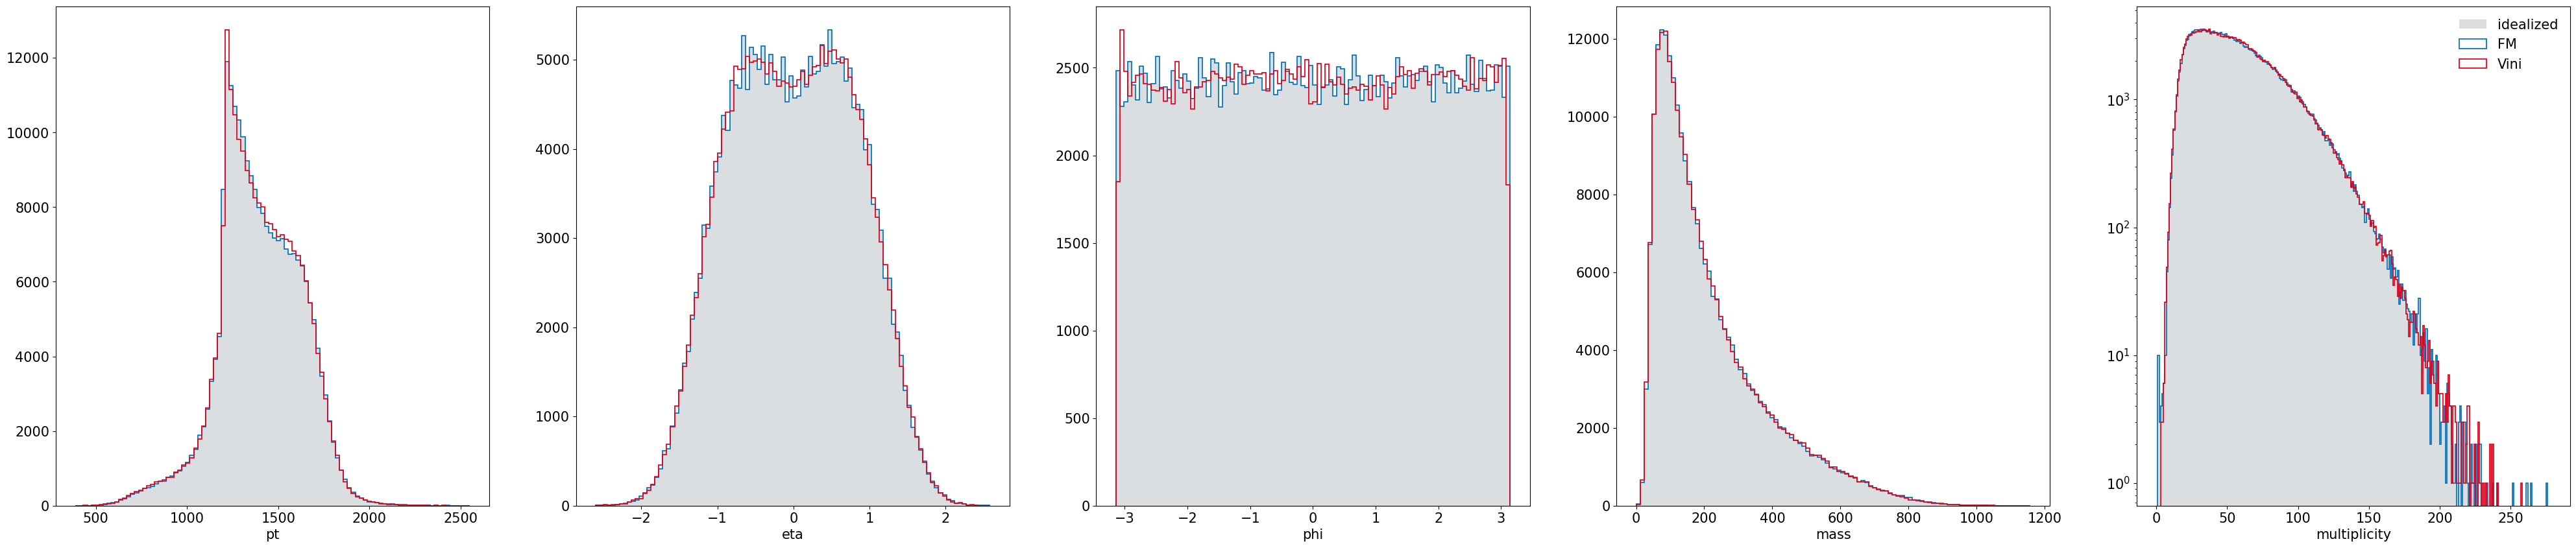

In [70]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 5, figsize=(50, 10))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(jet_data_id[..., i]), np.min(jet_data_c[...,i])), max(np.max(jet_data_id[..., i]), np.max(jet_data_c[...,i]))
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 100
    hist = ax.hist(jet_data_id[..., i].flatten(), bins=bins, alpha=0.5, label="idealized", histtype="stepfilled", range=(min_bin, max_bin))
    cycler = ax._get_lines.prop_cycler
    next(cycler)
    ax.hist(jet_data_c[..., i].flatten(), bins=hist[1], label="FM", histtype="step")
    ax.hist(jet_data_v[..., i].flatten(), bins=hist[1], label="Vini", histtype="step")
    ax.set_xlabel(labels[i])
plt.legend(frameon=False)
plt.show()

In [74]:
def sort_pt(array):
    
    pt = array[...,0]
    #print(pt[0,0,:10])
    eta = array[...,1]
    phi = array[...,2]
    args = np.argsort(pt, axis=-1)[...,::-1]
    #print(pt.shape)
    #print(args.shape)
    
    pt2 = np.take_along_axis(pt, args, axis=-1)
    #print(pt2[0,0,:10])
    eta2 = np.take_along_axis(eta, args, axis=-1)
    phi2 = np.take_along_axis(phi, args, axis=-1)
    return np.stack([pt2, eta2, phi2], axis=-1)

In [75]:
particle_data_id = sort_pt(particle_data_id)
particle_data_c = sort_pt(particle_data_c)
particle_data_v = sort_pt(particle_data_v)

In [76]:
def LoadJson(file_name):
    import json,yaml
    JSONPATH = os.path.join(file_name)
    return yaml.safe_load(open(JSONPATH))
def preprocess(particle):
    new_p = np.copy(particle).reshape((-1, particle.shape[-1]))

    mask = new_p[:, 0] != 0
    new_p[:, 0] = np.ma.log(1.0 - new_p[:, 0]).filled(0)
    data_dict = LoadJson('/home/ewencedr/LHCO_diffusion/scripts/preprocessing_279.json')
    new_p = np.ma.divide(new_p - data_dict["mean_particle"], data_dict["std_particle"]).filled(0)
    new_p *= np.expand_dims(mask, -1)
    new_p = np.reshape(new_p, particle.shape)
    return new_p

In [77]:
particle_data_id = preprocess(particle_data_id)
particle_data_c = preprocess(particle_data_c)
particle_data_v = preprocess(particle_data_v)
print(particle_data_id.shape)
print(particle_data_c.shape)
print(particle_data_v.shape)

(121351, 2, 279, 3)
(121351, 2, 279, 3)
(121351, 2, 279, 3)


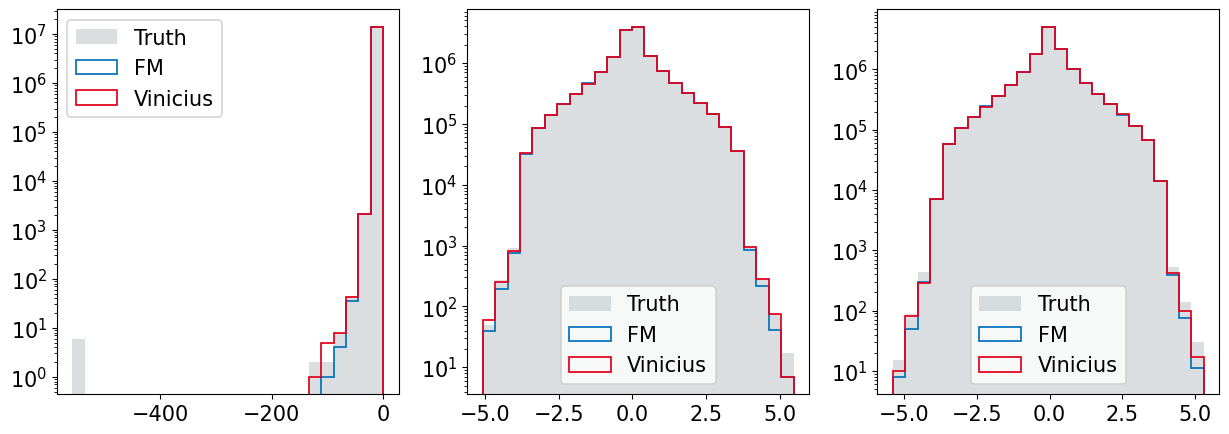

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(false_p[..., i]), np.min(correct_p[...,i])), max(np.max(false_p[..., i]), np.max(correct_p[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(particle_data_id[..., i].flatten()[particle_data_id[..., i].flatten() != 0], bins=bins, label="Truth", alpha=0.5)
    cycler = ax._get_lines.prop_cycler
    next(cycler)
    hist2 = ax.hist(particle_data_c[..., i].flatten()[particle_data_c[..., i].flatten() != 0], bins=hist[1], label="FM", histtype="step")
    hist3 = ax.hist(particle_data_v[..., i].flatten()[particle_data_v[..., i].flatten() != 0], bins=hist[1], label="Vinicius", histtype="step")
    
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

In [79]:
particle_data_c_full = particle_data_c.reshape(particle_data_c.shape[0]*particle_data_c.shape[1], -1)
particle_data_id_full = particle_data_id.reshape(particle_data_id.shape[0]*particle_data_id.shape[1], -1)
particle_data_v_full = particle_data_v.reshape(particle_data_v.shape[0]*particle_data_v.shape[1], -1)

print(particle_data_c_full.shape)
print(particle_data_id_full.shape)
print(particle_data_v_full.shape)

(242702, 837)
(242702, 837)
(242702, 837)


In [ ]:
fig, axs = plt.subplots(93, 9, figsize=(45, 465))
for i, ax in enumerate(axs.flatten()):
    #min_bin, max_bin = min(np.min(particle_data_id_full[..., i]), np.min(particle_data_c_full[...,i])), max(np.max(particle_data_id_full[..., i]), np.max(particle_data_c_full[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=100
    hist = ax.hist(particle_data_id_full[...,i].flatten()[particle_data_id_full[..., i].flatten() != 0], bins=bins, alpha=0.5, label="Truth", histtype="stepfilled")
    cycler = ax._get_lines.prop_cycler
    next(cycler)
    ax.hist(particle_data_c_full[...,i].flatten()[particle_data_c_full[..., i].flatten() != 0], bins=bins, label="FM", histtype="step")
    ax.hist(particle_data_v_full[...,i].flatten()[particle_data_v_full[..., i].flatten() != 0], bins=bins, label="Vini", histtype="step")
    
    #ax.hist(flat_data_v[...,i].flatten()[flat_data_v[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    #[false_p_flat[..., i].flatten() != 0]
    label=""
    if (i+1) % 3 == 1:
        label += " pt"
        ax.set_yscale("log")
        #print(min_bin, max_bin)
    if (i+1) % 3 == 2:
        label += " eta"
        #ax.set_yscale("log")
    if (i+1) % 3 == 0:
        label += " phi"
        #ax.set_yscale("log")
    #if i < flat_data_id.shape[-1]//2:
    #    label += " first jet"
    #else:
    #    label += " second jet"
    #ax.set_yscale("log")
    label += f"{(i//3)}"
    #for j in range(particle_data_id.shape[-2]):
    #    if (i+1) % ((j+1)*3) < 0:
    #        label += f" particle {i}"
    ax.set_xlabel(label)
    ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(93, 9, figsize=(45, 465))
for i, ax in enumerate(axs.flatten()):
    min_bin, max_bin = min(np.min(particle_data_id_full[..., i]), np.min(particle_data_c_full[...,i])), max(np.max(particle_data_id_full[..., i]), np.max(particle_data_c_full[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(particle_data_id_full[...,i].flatten()[particle_data_id_full[..., i].flatten() != 0], bins=bins, alpha=0.5, label="Truth", histtype="stepfilled", range=(min_bin, max_bin))
    cycler = ax._get_lines.prop_cycler
    next(cycler)
    ax.hist(particle_data_c_full[...,i].flatten()[particle_data_c_full[..., i].flatten() != 0], bins=hist[1], label="FM", histtype="step")
    ax.hist(particle_data_v_full[...,i].flatten()[particle_data_v_full[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    #ax.hist(flat_data_v[...,i].flatten()[flat_data_v[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    #[false_p_flat[..., i].flatten() != 0]
    label=""
    if (i+1) % 3 == 1:
        label += " pt"
        ax.set_yscale("log")
        #print(min_bin, max_bin)
    if (i+1) % 3 == 2:
        label += " eta"
        #ax.set_yscale("log")
    if (i+1) % 3 == 0:
        label += " phi"
        #ax.set_yscale("log")
    #if i < flat_data_id.shape[-1]//2:
    #    label += " first jet"
    #else:
    #    label += " second jet"
    #ax.set_yscale("log")
    label += f"{(i//3)}"
    #for j in range(particle_data_id.shape[-2]):
    #    if (i+1) % ((j+1)*3) < 0:
    #        label += f" particle {i}"
    ax.set_xlabel(label)
    ax.legend()
plt.tight_layout()
plt.savefig("particle_distributions.pdf")
plt.show()

In [74]:
particle_data_id_f = particle_data_id[..., [1, 2, 0]]
particle_data_c_f = particle_data_c[..., [1,2,0]]
particle_data_v_f = particle_data_v[..., [1,2,0]]
particle_data_id_f = particle_data_id_f.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1])
particle_data_c_f = particle_data_c_f.reshape(-1, particle_data_c.shape[-2], particle_data_c.shape[-1])
particle_data_v_f = particle_data_v_f.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1]) 

print(particle_data_c_f.shape)

(242702, 279, 3)


In [75]:
plot_config_x = {
    "num_samples": len(particle_data_id_f),
    "plot_jet_features": True,
    "plot_w_dists": False,
    "plot_efps": False,
    "plot_selected_multiplicities": True,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 5, 20],
    "plottype": "sim_data",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 100,
    "close_fig": False,
    "labels": ["FM","FPCD"]
}
plot_prep_config_x = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_x.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [76]:
(
    jet_data_x,
    efps_values_x,
    pt_selected_particles_x,
    pt_selected_multiplicities_x,
) = prepare_data_for_plotting(
    np.array([particle_data_c_f, particle_data_v_f]),
    **plot_prep_config_x,
)

In [77]:
(
    jet_data_sim_x,
    efps_sim_x,
    pt_selected_particles_sim_x,
    pt_selected_multiplicities_sim_x,
) = prepare_data_for_plotting(
    [particle_data_id_f],
    **plot_prep_config_x,
)
jet_data_sim_x, efps_sim_x, pt_selected_particles_sim_x = (
    jet_data_sim_x[0],
    efps_sim_x[0],
    pt_selected_particles_sim_x[0],
)

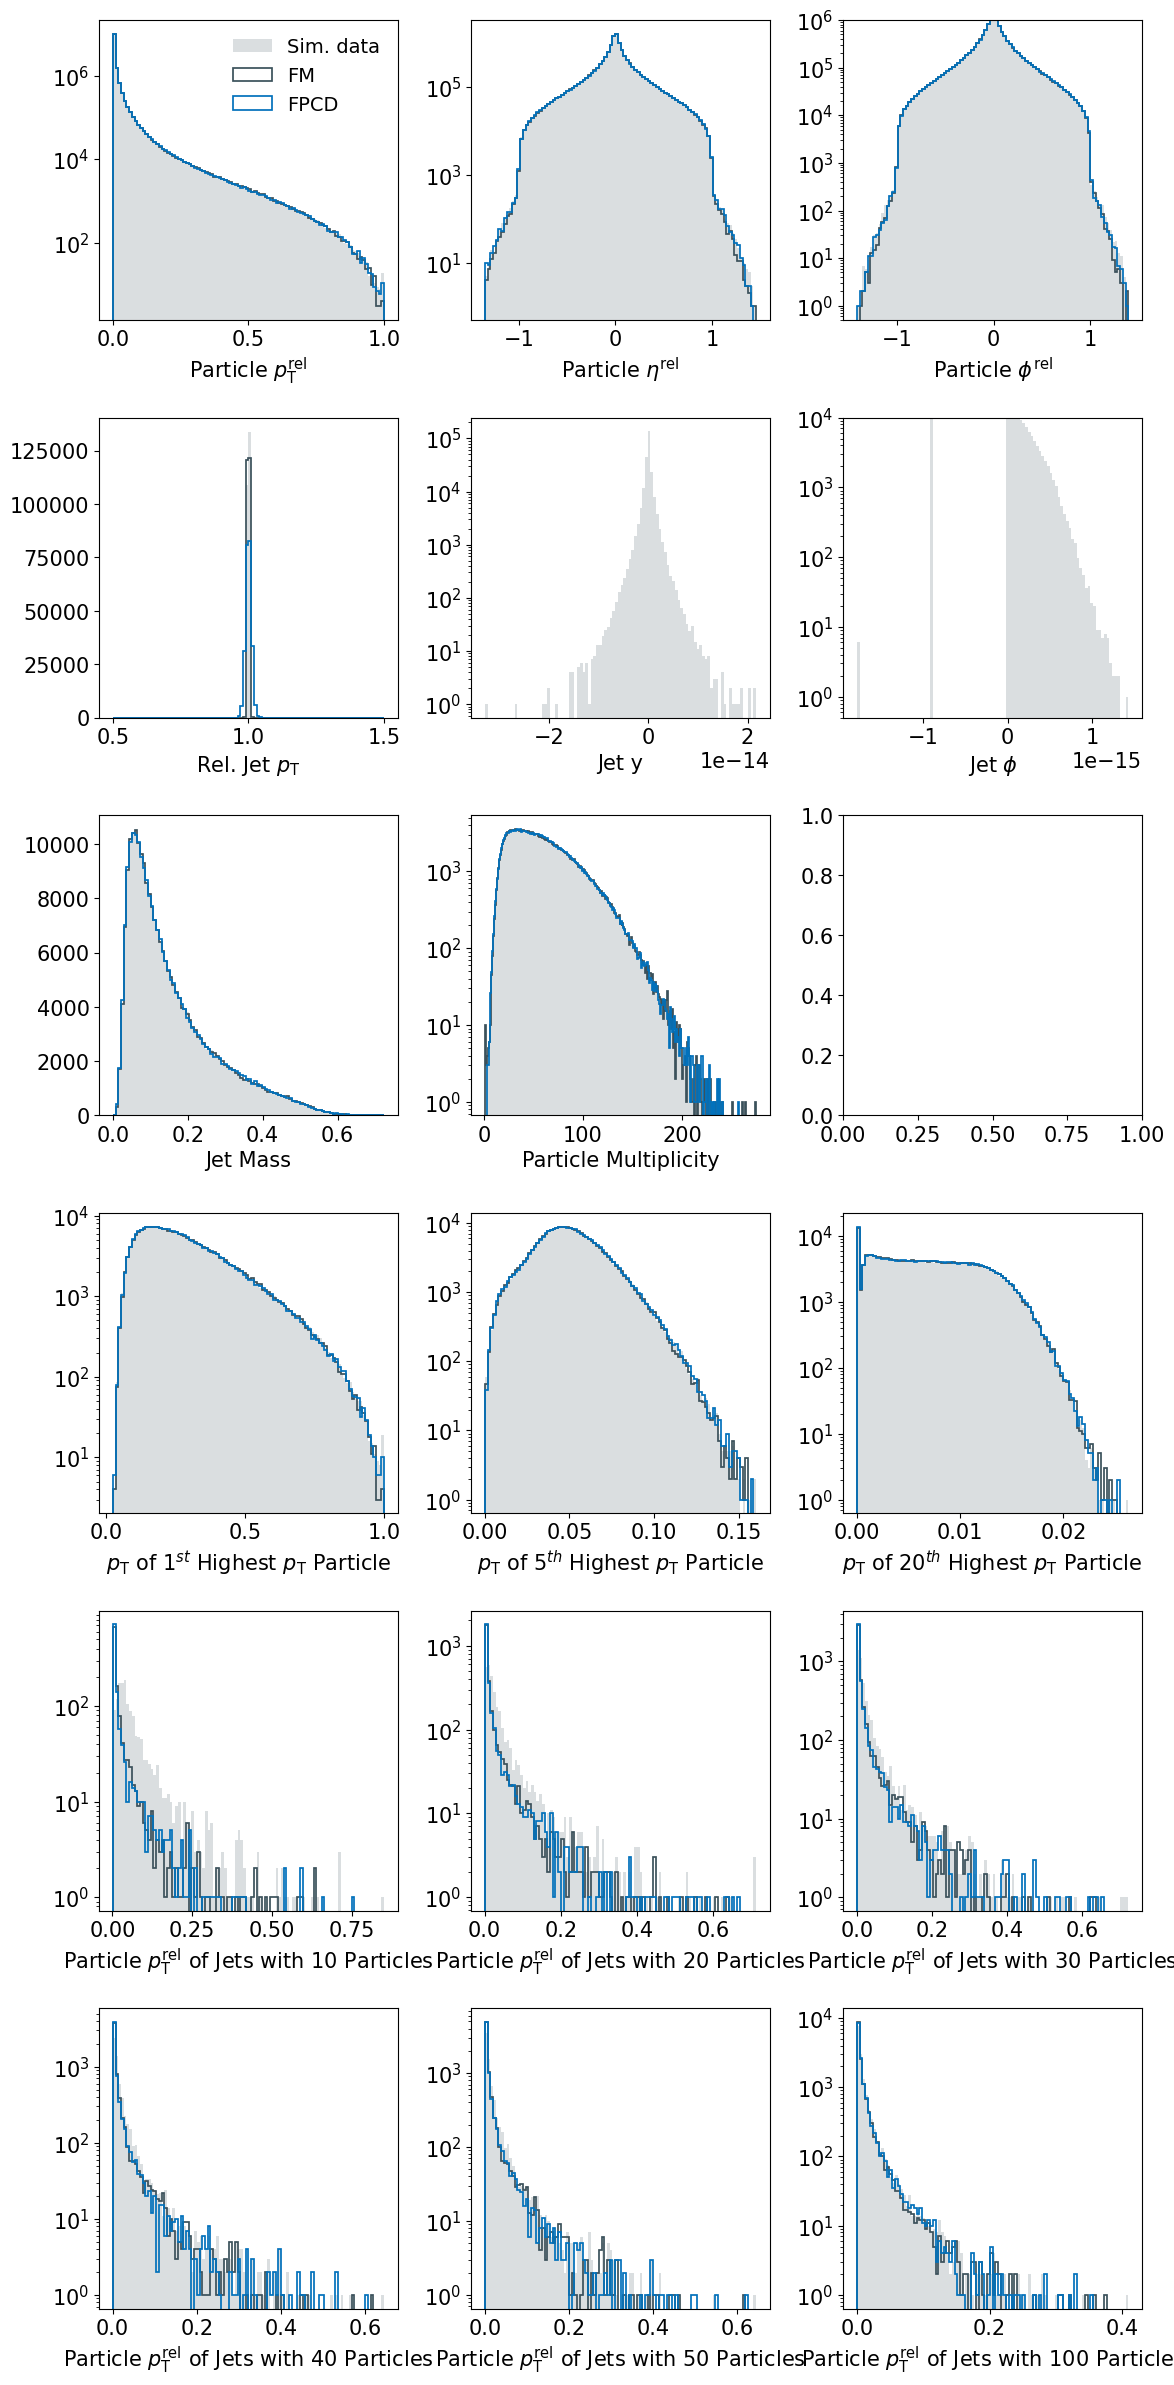

In [78]:
fig_x = plot_data(
    particle_data=np.array([particle_data_c_f, particle_data_v_f]),
    sim_data=particle_data_id_f,
    jet_data_sim=jet_data_sim_x,
    jet_data=jet_data_x,
    efps_sim=efps_sim_x,
    efps_values=efps_values_x,
    pt_selected_particles=pt_selected_particles_x,
    pt_selected_multiplicities=pt_selected_multiplicities_x,
    pt_selected_particles_sim=pt_selected_particles_sim_x,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_x,
    **plot_config_x,
)